# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [82]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter



In [79]:
import xgboost

## 1.1 Reading Data

In [3]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [4]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [5]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 1.2 preprocessing of `project_subject_categories`

In [6]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [7]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.3 Text preprocessing

In [8]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [9]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  
0  My students are English learners that are work...  
1  Our students arrive to our school eager to lea...

In [10]:
#### 1.4.2.3 Using Pretrained Models: TFIDF weighted W2V

In [11]:
# printing some random reviews
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[99999])
print("="*50)

My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

The mediocre teacher tells. The good teacher explains. The superior teacher demonstrates. The great teacher inspires. -William A. Ward\r\n\r\nMy school has 803 students which is makeup is 97.6% African-American, making up the largest segment of the student body. A typical school in Dallas is made up of 23.2% African-American students. Most of the students are on free or reduced lunch. We aren't receiving doctors, lawyers, or engineers children from rich backgrounds or neighborhoods. As an educator I am inspiring minds of young children and we focus not only on academics but one smart, effective, efficient, and disciplined students with good character.In our classroom we can utilize the Bluetooth for swift transitions during class. I use a speaker which doesn't amplify the sound enough to receive the message. Due to the volume of my speaker my students can't hear videos or books clearly and it isn't making the lessons as meaningful. But with the bluetooth speaker my students will be abl

In [12]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [14]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [15]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [16]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [17]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:56<00:00, 1938.30it/s]


In [18]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

<h2><font color='red'> 1.4 Preprocessing of `project_title`</font></h2>

In [19]:
# similarly you can preprocess the titles also
print(project_data['project_title'].values[0])
print('-'*100)
print(project_data['project_title'].values[289])
print('-'*100)
print(project_data['project_title'].values[1090])
print('-'*100)
print(project_data['project_title'].values[7])
print('-'*100)
print(project_data['project_title'].values[15000])
print('-'*100)
print(project_data['project_title'].values[15468])

Educational Support for English Learners at Home
----------------------------------------------------------------------------------------------------
Learning to Shred!
----------------------------------------------------------------------------------------------------
Coding: Bee-Bots to Discover Computer Science
----------------------------------------------------------------------------------------------------
It's the 21st Century
----------------------------------------------------------------------------------------------------
\r\nThe \"i\" Classroom
----------------------------------------------------------------------------------------------------
Mission: Target Learning


In [20]:
# let's decontract the titles by using the decontracted fuinction defined above
decon = decontracted(project_data['project_title'].values[7])
print(decon)

It is the 21st Century


In [21]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sen = project_data['project_title'].values[15000].replace('\\r',' ')
sen = sen.replace('\\"',' ')
sen = sen.replace('\\n',' ')
print(sen)

  The  i  Classroom


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', project_data['project_title'].values[15468])
print(sent)

Mission Target Learning


In [23]:
#let's combine all above and apply to all the data points
preprocessed_title = []
for sentances in tqdm(project_data['project_title'].values):
    sentance = decontracted(sentances)
    sentance = sentance.replace("\\r",' ')
    sentance = sentance.replace("\\n",' ')
    sentance = sentance.replace('\\"',' ')
    sentance = re.sub('[^A-Za-z0-9]+',' ',sentance)
    
    sentance = ' '.join(e for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_title.append(sentance.lower().strip())

100%|██████████| 109248/109248 [00:02<00:00, 43477.55it/s]


In [24]:
preprocessed_title[20000]

'need move input'

## 1.5 Preparing data for models

In [25]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

In [26]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

__ Computing Sentiment Scores__

In [27]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
    
ss = []
for es in tqdm(preprocessed_essays):
    ss.append(sid.polarity_scores(es))

senti_scores = pd.DataFrame(ss)

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

100%|██████████| 109248/109248 [02:56<00:00, 618.88it/s]


# Assignment 9: RF and GBDT

#### Response Coding: Example

<img src='response.JPG' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.5]

<ol>
    <li><strong>Apply both Random Forrest and GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(BOW) + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 3</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V). Here for this set take <b>20K</b> datapoints only. </li>
            <li><font color='red'>Set 4</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V). Here for this set take <b>20K</b> datapoints only. </li>        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters preferably n_estimators, max_depth)</strong>
        <ul>
          <li> Consider the following range for hyperparameters <b>n_estimators</b> = [10, 50, 100, 150, 200, 300, 500, 1000], 
            <b>max_depth</b> = [2, 3, 4, 5, 6, 7, 8, 9, 10] </li>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using simple cross validation data</li>
    <li>You can write your own for loops to do this task</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You can choose either of the plotting techniques: 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
            </ul>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

<h1>2. Random Forest and GBDT </h1>

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [28]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price',
       'quantity'],
      dtype='object')

In [29]:
senti_scores.columns

Index(['compound', 'neg', 'neu', 'pos'], dtype='object')

In [30]:
senti_scores.head()

compound    neg    neu    pos
0    0.9694  0.012  0.844  0.144
1    0.9856  0.048  0.669  0.283
2    0.9816  0.122  0.659  0.219
3    0.9656  0.106  0.649  0.246
4    0.8524  0.066  0.791  0.143

In [31]:
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved','Unnamed: 0','id','teacher_id','project_essay_1','project_essay_2','project_essay_3','project_essay_4','project_resource_summary','project_title','essay'], axis=1)
X['essay'] = preprocessed_essays
X['title'] = preprocessed_title
X[['compound','neg','neu','pos']] = senti_scores[['compound', 'neg', 'neu', 'pos']]
X['essay_cnt'] = [len(i.split()) for i in preprocessed_essays]
X['title_cnt'] = [len(i.split()) for i in preprocessed_title]


In [32]:
X.isna().sum()

teacher_prefix                                  3
school_state                                    0
project_submitted_datetime                      0
project_grade_category                          0
teacher_number_of_previously_posted_projects    0
clean_categories                                0
clean_subcategories                             0
price                                           0
quantity                                        0
essay                                           0
title                                           0
compound                                        0
neg                                             0
neu                                             0
pos                                             0
essay_cnt                                       0
title_cnt                                       0
dtype: int64

In [33]:
y = np.delete(y,X[X['teacher_prefix'].isna()].index,0)
X = X.dropna()

In [34]:
y

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [35]:
X = X.head(50000)
y = y[:50000]

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,stratify=y)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [37]:
len(X_test)

16500

<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

In [40]:
def response_enc(X,coun,col):

    ## Merge the school state with y_train in df
    df = pd.DataFrame(X[col], columns=[col])

    
    #initialize with temp nos
    df[col+'_0'] = 0
    df[col+'_1'] = 1

    for data in coun.index:
        df.loc[df[df[col] == data].index,col+'_0'] = coun.loc[data]['project_is_approved_0']/(coun.loc[data]['project_is_approved_0'] + coun.loc[data]['project_is_approved_1'])
        df.loc[df[df[col] == data].index,col+'_1'] = coun.loc[data]['project_is_approved_1']/(coun.loc[data]['project_is_approved_0'] + coun.loc[data]['project_is_approved_1'])     

    
    
    return df.drop([col],axis=1).values # returning it as a numpy matrix

In [41]:
def resp_fit(X,y,col):
    a = pd.DataFrame(X[col], columns=[col])
    a['project_is_approved'] = y

    ## Seperate out the df with y_train value = 0 and 1 respectevely
    a_1 = a[a.project_is_approved == 1]
    a_0 = a[a.project_is_approved == 0]

    ## group by school state for 0 and 1
    c_1 = a_1.groupby(col).count()
    c_0 = a_0.groupby(col).count()
    
    #initialize with temp nos
    #a['state_0'] = 0
    #a['state_1'] = 1
    
    coun = c_0.merge(c_1,on=col,suffixes=['_0', '_1'])
    
    return coun

In [42]:
'''for ind in tqdm(a.index):
    for data in coun.index:
        if data == a.loc[ind]['school_state']:
            a.loc[ind,'state_0'] = coun.loc[data]['project_is_approved_0']/(coun.loc[data]['project_is_approved_0'] + coun.loc[data]['project_is_approved_1'])
            a.loc[ind,'state_1'] = coun.loc[data]['project_is_approved_1']/(coun.loc[data]['project_is_approved_0'] + coun.loc[data]['project_is_approved_1'])    
'''

"for ind in tqdm(a.index):\n    for data in coun.index:\n        if data == a.loc[ind]['school_state']:\n            a.loc[ind,'state_0'] = coun.loc[data]['project_is_approved_0']/(coun.loc[data]['project_is_approved_0'] + coun.loc[data]['project_is_approved_1'])\n            a.loc[ind,'state_1'] = coun.loc[data]['project_is_approved_1']/(coun.loc[data]['project_is_approved_0'] + coun.loc[data]['project_is_approved_1'])    \n"

In [43]:
## It won't update in the main DF here 'a'
'''
for data in coun.index:
    a[a['school_state'] == data]['state_0'] = coun.loc[data]['project_is_approved_0']/(coun.loc[data]['project_is_approved_0'] + coun.loc[data]['project_is_approved_1'])
    a[a['school_state'] == data]['state_1'] = coun.loc[data]['project_is_approved_1']/(coun.loc[data]['project_is_approved_0'] + coun.loc[data]['project_is_approved_1'])     
    print(coun.loc[data]['project_is_approved_0']/(coun.loc[data]['project_is_approved_0'] + coun.loc[data]['project_is_approved_1']))
'''

"\nfor data in coun.index:\n    a[a['school_state'] == data]['state_0'] = coun.loc[data]['project_is_approved_0']/(coun.loc[data]['project_is_approved_0'] + coun.loc[data]['project_is_approved_1'])\n    a[a['school_state'] == data]['state_1'] = coun.loc[data]['project_is_approved_1']/(coun.loc[data]['project_is_approved_0'] + coun.loc[data]['project_is_approved_1'])     \n    print(coun.loc[data]['project_is_approved_0']/(coun.loc[data]['project_is_approved_0'] + coun.loc[data]['project_is_approved_1']))\n"

In [44]:
#cite : https://stackoverflow.com/questions/36909977/update-row-values-where-certain-condition-is-met-in-pandas
## We need to use a.loc[index,col_name] = val for updating    index can be list of indices too or a sing index(like above to above cell)

<h3>2.2.1 encoding categorical features: School State</h3>

In [45]:
coun=resp_fit(X_train,y_train,'school_state')
X_train_state = response_enc(X_train,coun,'school_state')
#X_cv_state = response_enc(X_cv,coun,'school_state')
X_test_state = response_enc(X_test,coun,'school_state')

<h3>2.2.2 encoding categorical features: teacher_prefix</h3>

In [47]:
coun=resp_fit(X_train,y_train,'teacher_prefix')
X_train_teacher = response_enc(X_train,coun,'teacher_prefix')
#X_cv_teacher = response_enc(X_cv,coun,'teacher_prefix')
X_test_teacher = response_enc(X_test,coun,'teacher_prefix')

<h3>2.2.3 encoding categorical features: clean_categories</h3>

In [48]:
coun=resp_fit(X_train,y_train,'clean_categories')
X_train_cat = response_enc(X_train,coun,'clean_categories')
#X_cv_cat = response_enc(X_cv,coun,'clean_categories')
X_test_cat = response_enc(X_test,coun,'clean_categories')

<h3>2.2.4 encoding categorical features: clean_subcategories</h3>

In [49]:
coun=resp_fit(X_train,y_train,'clean_subcategories')
X_train_subcat = response_enc(X_train,coun,'clean_subcategories')
#X_cv_subcat = response_enc(X_cv,coun,'clean_subcategories')
X_test_subcat = response_enc(X_test,coun,'clean_subcategories')

<h3>2.2.5 encoding categorical features: project_grade_category</h3>

In [50]:
coun=resp_fit(X_train,y_train,'project_grade_category')
X_train_grade = response_enc(X_train,coun,'project_grade_category')
#X_cv_grade = response_enc(X_cv,coun,'project_grade_category')
X_test_grade = response_enc(X_test,coun,'project_grade_category')

<h3>2.2.6 Scaling Numerical features: Price</h3>

In [52]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train['price'].values.reshape(-1,1))
X_train_price_std = std.transform(X_train['price'].values.reshape(-1,1))
#X_cv_price_std = std.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_std = std.transform(X_test['price'].values.reshape(-1,1))

print("After Scaling")
print(X_train_price_std, y_train.shape)
#print(X_cv_price_std, y_cv.shape)
print(X_test_price_std, y_test.shape)

print("="*100)

After Scaling
[[-0.70392568]
 [-0.49439189]
 [ 1.42117767]
 ...
 [-0.26248831]
 [-0.39814432]
 [-0.64363702]] (33500,)
[[ 0.14787702]
 [ 0.88986916]
 [-0.11261598]
 ...
 [-0.31572108]
 [-0.18816627]
 [-0.60475123]] (16500,)


<h3>2.2.7 Scaling Numerical features: teacher_number_of_previously_posted_projects </h3>

In [55]:
std = StandardScaler()
std.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_train_teach_prev_std = std.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
#X_cv_teach_prev_std = std.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_teach_prev_std = std.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_teach_prev_std, y_train.shape)
#print(X_cv_teach_prev_std, y_cv.shape)
print(X_test_teach_prev_std, y_test.shape)

print("="*100)

After vectorizations
[[ 1.79842938]
 [-0.40421651]
 [-0.36810756]
 ...
 [-0.40421651]
 [-0.07923597]
 [-0.33199861]] (33500,)
[[-0.40421651]
 [ 0.71516091]
 [-0.22367176]
 ...
 [-0.40421651]
 [-0.29588966]
 [-0.33199861]] (16500,)


<h3>2.2.8 Scaling Numerical features: Quantity</h3>

In [56]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train['quantity'].values.reshape(-1,1))
X_train_quan_std = std.transform(X_train['quantity'].values.reshape(-1,1))
#X_cv_quan_std = std.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quan_std = std.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_quan_std, y_train.shape)
#print(X_cv_quan_std, y_cv.shape)
print(X_test_quan_std, y_test.shape)

print("="*100)

After vectorizations
[[-0.19061328]
 [-0.48885341]
 [-0.41429338]
 ...
 [-0.19061328]
 [-0.33973335]
 [-0.52613343]] (33500,)
[[-0.11605325]
 [-0.33973335]
 [-0.33973335]
 ...
 [-0.26517331]
 [ 0.25674692]
 [-0.19061328]] (16500,)


<h3>2.2.9 Scaling Numerical features: Title Count</h3>

In [57]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train['title_cnt'].values.reshape(-1,1))
X_train_title_cnt_std = std.transform(X_train['title_cnt'].values.reshape(-1,1))
#X_cv_title_cnt_std = std.transform(X_cv['title_cnt'].values.reshape(-1,1))
X_test_title_cnt_std = std.transform(X_test['title_cnt'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_title_cnt_std, y_train.shape)
#print(X_cv_title_cnt_std, y_cv.shape)
print(X_test_title_cnt_std, y_test.shape)

print("="*100)

After vectorizations
[[ 0.20434563]
 [-1.11122633]
 [-0.45344035]
 ...
 [ 1.5199176 ]
 [ 0.86213161]
 [ 0.20434563]] (33500,)
[[-0.45344035]
 [-1.11122633]
 [-1.11122633]
 ...
 [-0.45344035]
 [ 0.20434563]
 [ 0.86213161]] (16500,)


<h3>2.2.10 Scaling Numerical features: Essay Count</h3>

In [58]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train['essay_cnt'].values.reshape(-1,1))
X_train_essay_cnt_std = std.transform(X_train['essay_cnt'].values.reshape(-1,1))
#X_cv_essay_cnt_std = std.transform(X_cv['essay_cnt'].values.reshape(-1,1))
X_test_essay_cnt_std = std.transform(X_test['essay_cnt'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_essay_cnt_std, y_train.shape)
#print(X_cv_essay_cnt_std, y_cv.shape)
print(X_test_essay_cnt_std, y_test.shape)

print("="*100)

After vectorizations
[[-0.52615779]
 [-0.06290754]
 [ 1.8158296 ]
 ...
 [-0.55189392]
 [ 1.55846835]
 [-0.11437979]] (33500,)
[[-0.50042167]
 [ 0.88932909]
 [ 0.42607884]
 ...
 [-0.47468554]
 [-0.52615779]
 [-0.52615779]] (16500,)


<h2>2.3 Make Data Model Ready: encoding essay, and project_title</h2>

<h3>2.3.1 Vectorizing Essay </h3>

<h4>2.3.1.1 Vectorizing Essay : BOW </h4>

In [59]:
vectorizer = CountVectorizer(min_df=10)
X_train_essay_bow = vectorizer.fit_transform(X_train['essay'])
#X_cv_essay_bow = vectorizer.transform(X_cv['essay'])
X_test_essay_bow = vectorizer.transform(X_test['essay'])

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
#print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

print("="*100)

After vectorizations
(33500, 10446) (33500,)
(16500, 10446) (16500,)


<h4>2.3.1.2 Vectorizing Essay : TFidf </h4>

In [60]:
vectorizer = TfidfVectorizer(min_df=10)
X_train_essay_tfidf = vectorizer.fit_transform(X_train['essay'])
#X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'])
X_test_essay_tfidf = vectorizer.transform(X_test['essay'])

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
#print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

print("="*100)

After vectorizations
(33500, 10446) (33500,)
(16500, 10446) (16500,)


In [61]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

<h4>2.3.1.3 Vectorizing Essay : AvgW2v </h4>

In [62]:
# average Word2Vec
# compute average word2vec for each review.


def avg_w2v(preprocessed_essays):
    avg_w2v_vectors = []
    for sentence in tqdm(preprocessed_essays): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    return avg_w2v_vectors

X_train_essay_avg_w2v = avg_w2v(X_train['essay'])
#X_cv_essay_avg_w2v = avg_w2v(X_cv['essay'])
X_test_essay_avg_w2v = avg_w2v(X_test['essay'])

print("After vectorizations")
print(len(X_train_essay_avg_w2v), y_train.shape)
#print(len(X_cv_essay_avg_w2v), y_cv.shape)
print(len(X_test_essay_avg_w2v), y_test.shape)

print("="*100)



100%|██████████| 16500/16500 [00:04<00:00, 3668.33it/s]


After vectorizations
33500 (33500,)
16500 (16500,)


In [63]:
len(X_train['essay'])

33500

<h4>2.3.1.4 Vectorizing Essay : TFidf W2V</h4>

In [64]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

### Creating dictionary only for training pts.

In [65]:
 # the avg-w2v for each sentence/review is stored in this list
def tfidf_w2v(preprocessed_essays):
    tfidf_w2v_vectors = []
    for sentence in tqdm(preprocessed_essays): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    
    return tfidf_w2v_vectors

X_train_essay_tfidf_w2v = tfidf_w2v(X_train['essay'])
#X_cv_essay_tfidf_w2v = tfidf_w2v(X_cv['essay'])
X_test_essay_tfidf_w2v = tfidf_w2v(X_test['essay'])

print("After vectorizations")
print(len(X_train_essay_tfidf_w2v), y_train.shape)
#print(len(X_cv_essay_tfidf_w2v), y_cv.shape)
print(len(X_test_essay_tfidf_w2v), y_test.shape)

print("="*100)


100%|██████████| 16500/16500 [00:31<00:00, 524.10it/s]


After vectorizations
33500 (33500,)
16500 (16500,)


In [66]:
len(X_train['essay'])

33500

<h3>2.3.2 Vectorizing Title </h3>

<h4>2.3.2.1 Vectorizing Title : BOW </h4>

In [67]:
vectorizer = CountVectorizer(min_df=10)
X_train_title_bow = vectorizer.fit_transform(X_train['title'])
#X_cv_title_bow = vectorizer.transform(X_cv['title'])
X_test_title_bow = vectorizer.transform(X_test['title'])

print("After vectorizations")
print(X_train_title_bow.shape, y_train.shape)
#print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)

print("="*100)

After vectorizations
(33500, 1542) (33500,)
(16500, 1542) (16500,)


<h4>2.3.2.2 Vectorizing Title : TfIdf </h4>

In [68]:
vectorizer = TfidfVectorizer(min_df=10)
X_train_title_tfidf = vectorizer.fit_transform(X_train['title'])
#X_cv_title_tfidf = vectorizer.transform(X_cv['title'])
X_test_title_tfidf = vectorizer.transform(X_test['title'])

print("After vectorizations")
print(X_train_title_tfidf.shape, y_train.shape)
#print(X_cv_title_tfidf.shape, y_cv.shape)
print(X_test_title_tfidf.shape, y_test.shape)

print("="*100)

After vectorizations
(33500, 1542) (33500,)
(16500, 1542) (16500,)


<h4>2.3.2.3 Vectorizing Title : Avg W2V </h4>

In [69]:
def avg_w2v(preprocessed_essays):
    avg_w2v_vectors = []
    for sentence in tqdm(preprocessed_essays): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    return avg_w2v_vectors

X_train_title_avg_w2v = avg_w2v(X_train['title'])
#X_cv_title_avg_w2v = avg_w2v(X_cv['title'])
X_test_title_avg_w2v = avg_w2v(X_test['title'])

print("After vectorizations")
print(len(X_train_title_avg_w2v), y_train.shape)
#print(len(X_cv_title_avg_w2v), y_cv.shape)
print(len(X_test_title_avg_w2v), y_test.shape)

print("="*100)

100%|██████████| 16500/16500 [00:00<00:00, 73631.25it/s]


After vectorizations
33500 (33500,)
16500 (16500,)


In [70]:
type(X_train_title_avg_w2v)

list

<h4>2.3.2.4 Vectorizing Title : TfIdf W2V </h4>

In [71]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

### Creating dictionary only for training pts.

In [72]:
 # the avg-w2v for each sentence/review is stored in this list
def tfidf_w2v(preprocessed_essays):
    tfidf_w2v_vectors = []
    for sentence in tqdm(preprocessed_essays): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    
    return tfidf_w2v_vectors

X_train_title_tfidf_w2v = tfidf_w2v(X_train['title'])
#X_cv_title_tfidf_w2v = tfidf_w2v(X_cv['title'])
X_test_title_tfidf_w2v = tfidf_w2v(X_test['title'])

print("After vectorizations")
print(len(X_train_title_tfidf_w2v), y_train.shape)
#print(len(X_cv_title_tfidf_w2v), y_cv.shape)
print(len(X_test_title_tfidf_w2v), y_test.shape)

print("="*100)

100%|██████████| 16500/16500 [00:00<00:00, 36201.54it/s]


After vectorizations
33500 (33500,)
16500 (16500,)


<h2>2.4 Applying Random Forest</h2>

<br>Apply Random Forest on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [121]:
def rf_tune(X_train,y_train):
    
    params = {'n_estimators': [300, 500, 700,1000] , 'max_depth':[7, 8, 9, 10]}  ## Because we know Rf needs deep trees
    bm = RandomForestClassifier()
    clf = GridSearchCV(bm, param_grid=params,cv = 3,scoring='roc_auc', verbose = 48)
    clf.fit(X_train,y_train)
    
    cv_res = clf.cv_results_
    
    df1 = pd.DataFrame(data=list(cv_res['param_max_depth']),columns = ['max_dep'])
    df1['n_est'] = cv_res['param_n_estimators']
    df1['Train_AUC'] = cv_res['mean_train_score']
    pivotted = df1.pivot('n_est','max_dep','Train_AUC')
    plt.figure(figsize=(7,7))
    sns.heatmap(pivotted, annot=True ,fmt = '.2f')
    plt.title("Train AUC vs max_dep vs n_est")
    plt.show()

    df2 = pd.DataFrame(data=list(cv_res['param_max_depth']),columns = ['max_dep'])
    df2['n_est'] = cv_res['param_n_estimators']
    df2['CV_AUC'] = cv_res['mean_test_score']
    pivotted = df2.pivot('n_est','max_dep','CV_AUC')
    plt.figure(figsize=(7,7))
    sns.heatmap(pivotted, annot=True ,fmt = '.2f',cmap="YlGnBu")
    plt.title("Test AUC vs max_dep vs n_est")
    plt.show()
    
    print(clf.best_score_)
    print(clf.best_estimator_)
    print(clf.best_params_)
    
    return clf

In [122]:
def predict(X_tr,X_te,y_train,y_test,clf):
    
    clf.fit(X_tr,y_train)
    
    y_test_prob = clf.predict_proba(X_te)[:,1]
    y_train_prob = clf.predict_proba(X_tr)[:,1]
    
    print(y_test.shape)
    print(y_test_prob.shape)

    train_fpr, train_tpr, tr_the = roc_curve(y_train, y_train_prob)
    test_fpr, test_tpr ,te_the = roc_curve(y_test,y_test_prob)
    
    plt.figure(figsize=(8,8))
    plt.style.use('default')

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.grid()
    plt.show()
    
    best_t = find_best_threshold(tr_the, train_fpr, train_tpr)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax1.set_title('Train Confusion Matrix')
    ax2.set_title('Test Confusion Matrix')
    sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_prob, best_t)), annot=True ,fmt = 'd', ax = ax1,cmap="YlGnBu")
    sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_prob, best_t)), annot=True ,fmt = 'd', ax= ax2)# #annot=True to annotate cells
    #sns.heatmap(confusion_matrix(y_train, calibrated_clf.predict(X_tr)), annot=True ,fmt = 'd', ax = ax1,cmap="YlGnBu")
    #sns.heatmap(confusion_matrix(y_test, calibrated_clf.predict(X_te)), annot=True ,fmt = 'd', ax= ax2)# #annot=True to annotate cells
    #sns.heatmap(confusion_matrix(y_train, classifier.predict(X_tr)), annot=True ,fmt = 'd', ax = ax1,cmap="YlGnBu")
    #sns.heatmap(confusion_matrix(y_test, classifier.predict(X_te)), annot=True ,fmt = 'd', ax= ax2)
    fig.tight_layout()
    
    a = pd.DataFrame()
    a['y_test'] = y_test
    a['pred'] = predict_with_best_t(y_test_prob, best_t)
    
    ## Getting the indexes of all the False positives
    
    
    return auc(train_fpr, train_tpr), auc(test_fpr, test_tpr)

In [123]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

### 2.4.1 Applying Random Forests on BOW,<font color='red'> SET 1</font>

#### 2.4.1.1 Concatnating Matrices

In [138]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_cat, X_train_subcat, X_train_essay_bow, X_train_title_bow, X_train_state, X_train_teacher, X_train_grade, X_train_price_std, X_train_teach_prev_std,X_train_essay_cnt_std,X_train['pos'].values.reshape(-1,1),X_train['neg'].values.reshape(-1,1),X_train['neu'].values.reshape(-1,1),X_train['compound'].values.reshape(-1,1))).tocsr()
X_te = hstack((X_test_cat, X_test_subcat, X_test_essay_bow, X_test_title_bow, X_test_state, X_test_teacher, X_test_grade, X_test_price_std, X_test_teach_prev_std,X_test_essay_cnt_std,X_test['pos'].values.reshape(-1,1),X_test['neg'].values.reshape(-1,1),X_test['neu'].values.reshape(-1,1),X_test['compound'].values.reshape(-1,1))).tocsr()
#X_cr = hstack((X_cv_cat, X_cv_subcat, X_cv_essay_bow, X_cv_title_bow, X_cv_state, X_cv_teacher, X_cv_grade, X_cv_price_std, X_cv_teach_prev_std,X_cv_essay_cnt_std,X_cv['pos'].values.reshape(-1,1),X_cv['neg'].values.reshape(-1,1),X_cv['neu'].values.reshape(-1,1),X_cv['compound'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
#print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 12005) (33500,)
(16500, 12005) (16500,)


#### 2.4.1.2 HyperParameter Tuning and Heat Map

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=7, n_estimators=300 ...................................
[CV]  max_depth=7, n_estimators=300, score=0.6813328001478858, total=   3.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] max_depth=7, n_estimators=300 ...................................
[CV]  max_depth=7, n_estimators=300, score=0.6779629341472954, total=   3.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s


[CV] max_depth=7, n_estimators=300 ...................................
[CV]  max_depth=7, n_estimators=300, score=0.6647295187328348, total=   3.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.8s remaining:    0.0s


[CV] max_depth=7, n_estimators=500 ...................................
[CV]  max_depth=7, n_estimators=500, score=0.6821143875754271, total=   5.9s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   26.6s remaining:    0.0s


[CV] max_depth=7, n_estimators=500 ...................................
[CV]  max_depth=7, n_estimators=500, score=0.6768834118362254, total=   6.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.8s remaining:    0.0s


[CV] max_depth=7, n_estimators=500 ...................................
[CV]  max_depth=7, n_estimators=500, score=0.6663744004021996, total=   6.3s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   46.6s remaining:    0.0s


[CV] max_depth=7, n_estimators=700 ...................................
[CV]  max_depth=7, n_estimators=700, score=0.6833769849727249, total=   8.6s


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   60.0s remaining:    0.0s


[CV] max_depth=7, n_estimators=700 ...................................
[CV]  max_depth=7, n_estimators=700, score=0.6806562089555981, total=   7.7s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.2min remaining:    0.0s


[CV] max_depth=7, n_estimators=700 ...................................
[CV]  max_depth=7, n_estimators=700, score=0.6689192629355954, total=   8.0s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.4min remaining:    0.0s


[CV] max_depth=7, n_estimators=1000 ..................................
[CV]  max_depth=7, n_estimators=1000, score=0.6834207718135902, total=  11.3s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.7min remaining:    0.0s


[CV] max_depth=7, n_estimators=1000 ..................................
[CV]  max_depth=7, n_estimators=1000, score=0.6861857648580887, total=  11.3s


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:  2.0min remaining:    0.0s


[CV] max_depth=7, n_estimators=1000 ..................................
[CV]  max_depth=7, n_estimators=1000, score=0.6663491276408499, total=  28.5s


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  2.6min remaining:    0.0s


[CV] max_depth=8, n_estimators=300 ...................................
[CV]  max_depth=8, n_estimators=300, score=0.6768991750989368, total=   4.0s


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:  2.7min remaining:    0.0s


[CV] max_depth=8, n_estimators=300 ...................................
[CV]  max_depth=8, n_estimators=300, score=0.6811660414213068, total=   3.7s


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  2.8min remaining:    0.0s


[CV] max_depth=8, n_estimators=300 ...................................
[CV]  max_depth=8, n_estimators=300, score=0.662393356326012, total=   3.8s


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.9min remaining:    0.0s


[CV] max_depth=8, n_estimators=500 ...................................
[CV]  max_depth=8, n_estimators=500, score=0.6838645399229057, total=   6.1s


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  3.1min remaining:    0.0s


[CV] max_depth=8, n_estimators=500 ...................................
[CV]  max_depth=8, n_estimators=500, score=0.6821120830048552, total=   6.1s


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:  3.2min remaining:    0.0s


[CV] max_depth=8, n_estimators=500 ...................................
[CV]  max_depth=8, n_estimators=500, score=0.6707934441842149, total=   6.4s


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  3.4min remaining:    0.0s


[CV] max_depth=8, n_estimators=700 ...................................
[CV]  max_depth=8, n_estimators=700, score=0.6864459969670622, total=   9.5s


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  3.6min remaining:    0.0s


[CV] max_depth=8, n_estimators=700 ...................................
[CV]  max_depth=8, n_estimators=700, score=0.6842440258770703, total=   8.8s


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.9min remaining:    0.0s


[CV] max_depth=8, n_estimators=700 ...................................
[CV]  max_depth=8, n_estimators=700, score=0.672267627105387, total=   8.6s


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  4.1min remaining:    0.0s


[CV] max_depth=8, n_estimators=1000 ..................................
[CV]  max_depth=8, n_estimators=1000, score=0.6823056054776754, total=  13.6s


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  4.4min remaining:    0.0s


[CV] max_depth=8, n_estimators=1000 ..................................
[CV]  max_depth=8, n_estimators=1000, score=0.6801745844336891, total=  14.3s


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:  4.8min remaining:    0.0s


[CV] max_depth=8, n_estimators=1000 ..................................
[CV]  max_depth=8, n_estimators=1000, score=0.666823099525241, total=  14.6s


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  5.2min remaining:    0.0s


[CV] max_depth=9, n_estimators=300 ...................................
[CV]  max_depth=9, n_estimators=300, score=0.6783852236588812, total=   4.3s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  5.3min remaining:    0.0s


[CV] max_depth=9, n_estimators=300 ...................................
[CV]  max_depth=9, n_estimators=300, score=0.6795257402710864, total=   4.5s


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:  5.4min remaining:    0.0s


[CV] max_depth=9, n_estimators=300 ...................................
[CV]  max_depth=9, n_estimators=300, score=0.6661846394739133, total=   4.4s


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  5.5min remaining:    0.0s


[CV] max_depth=9, n_estimators=500 ...................................
[CV]  max_depth=9, n_estimators=500, score=0.6867642735268387, total=   7.1s


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  5.7min remaining:    0.0s


[CV] max_depth=9, n_estimators=500 ...................................
[CV]  max_depth=9, n_estimators=500, score=0.6835283184402765, total=   6.8s


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:  5.9min remaining:    0.0s


[CV] max_depth=9, n_estimators=500 ...................................
[CV]  max_depth=9, n_estimators=500, score=0.6640770387555028, total=   7.0s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.0min remaining:    0.0s


[CV] max_depth=9, n_estimators=700 ...................................
[CV]  max_depth=9, n_estimators=700, score=0.6870579987281228, total=   9.7s


[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:  6.3min remaining:    0.0s


[CV] max_depth=9, n_estimators=700 ...................................
[CV]  max_depth=9, n_estimators=700, score=0.6827805928363376, total=   9.9s


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  6.5min remaining:    0.0s


[CV] max_depth=9, n_estimators=700 ...................................
[CV]  max_depth=9, n_estimators=700, score=0.6719190351732888, total=   9.6s


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  6.8min remaining:    0.0s


[CV] max_depth=9, n_estimators=1000 ..................................
[CV]  max_depth=9, n_estimators=1000, score=0.6861398270846899, total=  13.9s


[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  7.1min remaining:    0.0s


[CV] max_depth=9, n_estimators=1000 ..................................
[CV]  max_depth=9, n_estimators=1000, score=0.6826764262464899, total=  13.6s


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  7.5min remaining:    0.0s


[CV] max_depth=9, n_estimators=1000 ..................................
[CV]  max_depth=9, n_estimators=1000, score=0.6765812139878524, total=  13.8s


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  7.8min remaining:    0.0s


[CV] max_depth=10, n_estimators=300 ..................................
[CV]  max_depth=10, n_estimators=300, score=0.6820313615796252, total=   4.6s


[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:  7.9min remaining:    0.0s


[CV] max_depth=10, n_estimators=300 ..................................
[CV]  max_depth=10, n_estimators=300, score=0.6787086931843462, total=   4.5s


[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:  8.0min remaining:    0.0s


[CV] max_depth=10, n_estimators=300 ..................................
[CV]  max_depth=10, n_estimators=300, score=0.6729475320256924, total=   4.5s


[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  8.1min remaining:    0.0s


[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=10, n_estimators=500, score=0.6825513648834576, total=   7.6s


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  8.3min remaining:    0.0s


[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=10, n_estimators=500, score=0.6802427382674004, total=   7.5s


[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:  8.5min remaining:    0.0s


[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=10, n_estimators=500, score=0.6706821456488299, total=   7.7s


[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:  8.7min remaining:    0.0s


[CV] max_depth=10, n_estimators=700 ..................................
[CV]  max_depth=10, n_estimators=700, score=0.687309412013708, total=  10.5s


[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:  9.0min remaining:    0.0s


[CV] max_depth=10, n_estimators=700 ..................................
[CV]  max_depth=10, n_estimators=700, score=0.6865780334970254, total=  10.5s


[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:  9.2min remaining:    0.0s


[CV] max_depth=10, n_estimators=700 ..................................
[CV]  max_depth=10, n_estimators=700, score=0.6721733000593756, total=  10.7s


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  9.5min remaining:    0.0s


[CV] max_depth=10, n_estimators=1000 .................................
[CV]  max_depth=10, n_estimators=1000, score=0.6878301220525157, total=  14.9s


[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:  9.8min remaining:    0.0s


[CV] max_depth=10, n_estimators=1000 .................................
[CV]  max_depth=10, n_estimators=1000, score=0.6855943198665291, total=  15.3s


[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed: 10.2min remaining:    0.0s


[CV] max_depth=10, n_estimators=1000 .................................
[CV]  max_depth=10, n_estimators=1000, score=0.6698883595751913, total=  15.3s


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 10.6min finished


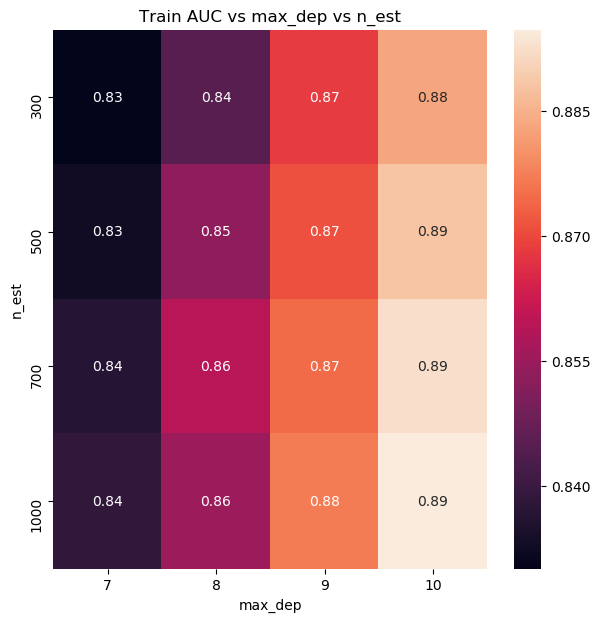

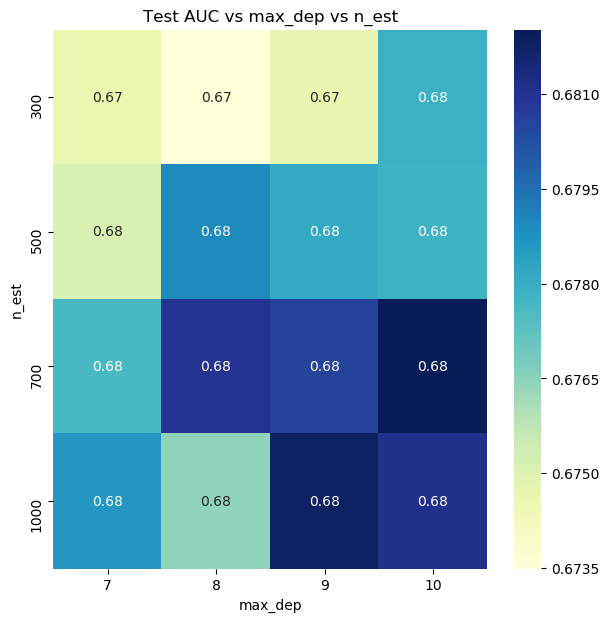

0.6820205424621298
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'max_depth': 10, 'n_estimators': 700}


In [125]:
result = rf_tune(X_tr,y_train)

#### 2.4.1.3 Predicting with best threshold

(16500,)
(16500,)


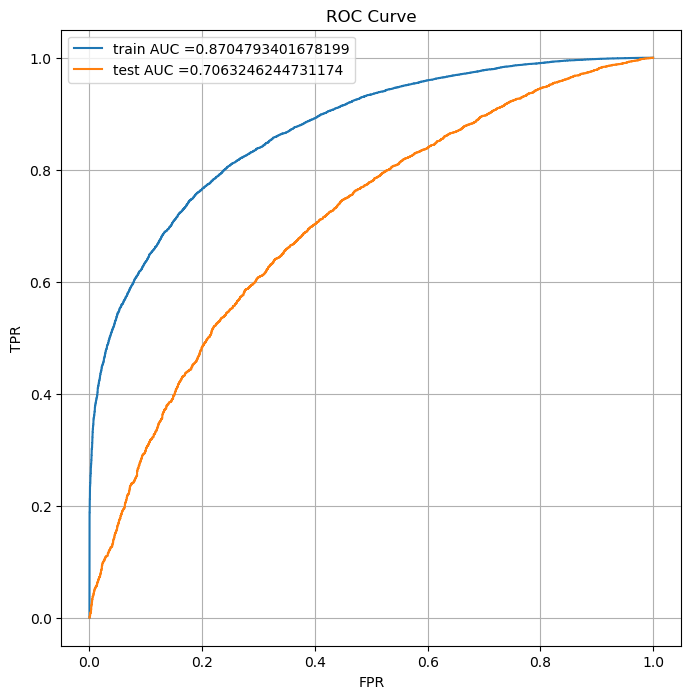

the maximum value of tpr*(1-fpr) 0.6137635397010852 for threshold 0.505


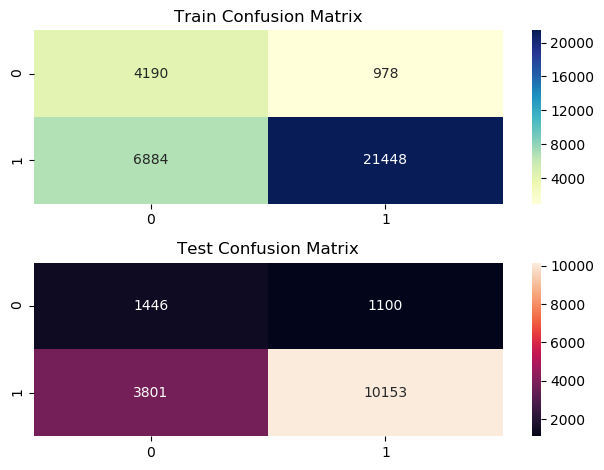

In [139]:
rf_tr_auc, rf_te_auc = predict(X_tr,X_te,y_train,y_test,RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))

### 2.4.2 Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [140]:
# Please write all the code with proper documentation
from scipy.sparse import hstack
X_tr = hstack((X_train_cat, X_train_subcat, X_train_essay_tfidf, X_train_title_tfidf, X_train_state, X_train_teacher, X_train_grade, X_train_price_std, X_train_teach_prev_std,X_train_essay_cnt_std,X_train['pos'].values.reshape(-1,1),X_train['neg'].values.reshape(-1,1),X_train['neu'].values.reshape(-1,1),X_train['compound'].values.reshape(-1,1))).tocsr()
X_te = hstack((X_test_cat, X_test_subcat, X_test_essay_tfidf, X_test_title_tfidf, X_test_state, X_test_teacher, X_test_grade, X_test_price_std, X_test_teach_prev_std,X_test_essay_cnt_std,X_test['pos'].values.reshape(-1,1),X_test['neg'].values.reshape(-1,1),X_test['neu'].values.reshape(-1,1),X_test['compound'].values.reshape(-1,1))).tocsr()
#X_cr = hstack((X_cv_cat, X_cv_subcat, X_cv_essay_tfidf, X_cv_title_tfidf, X_cv_state, X_cv_teacher, X_cv_grade, X_cv_price_std, X_cv_teach_prev_std,X_cv_essay_cnt_std,X_cv['pos'].values.reshape(-1,1),X_cv['neg'].values.reshape(-1,1),X_cv['neu'].values.reshape(-1,1),X_cv['compound'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
#print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 12005) (33500,)
(16500, 12005) (16500,)


#### 2.4.2.2 HyperParameter Tuning and Heat Map

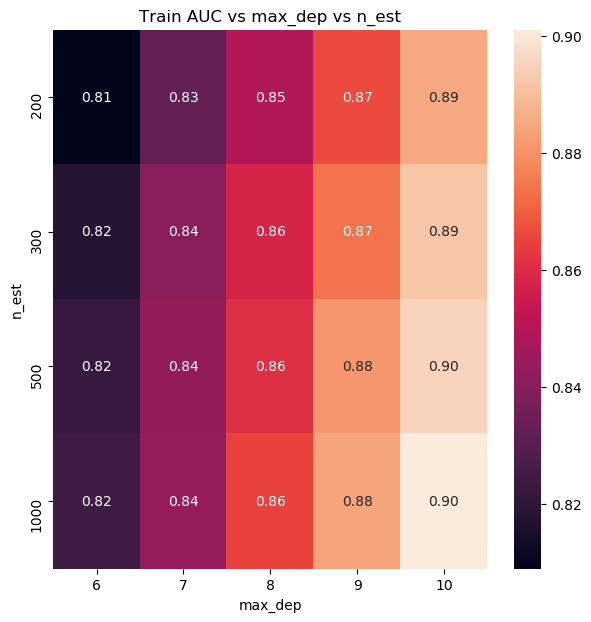

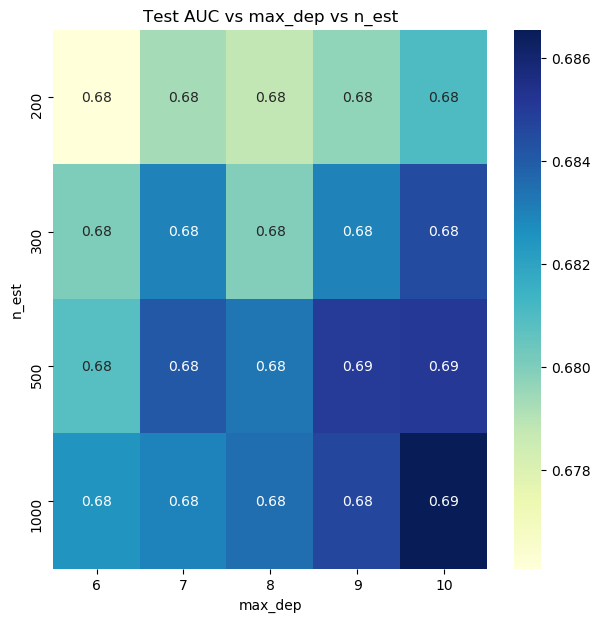

0.686546167096991
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'max_depth': 10, 'n_estimators': 1000}


In [113]:
result = rf_tune(X_tr,y_train)

#### 2.4.2.3 Predicting with best threshold

(16500,)
(16500,)


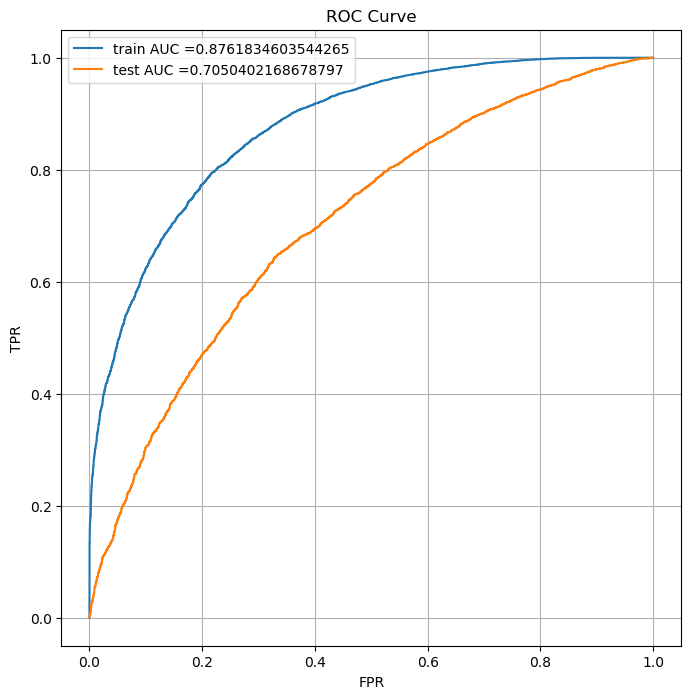

the maximum value of tpr*(1-fpr) 0.6219976186823288 for threshold 0.506


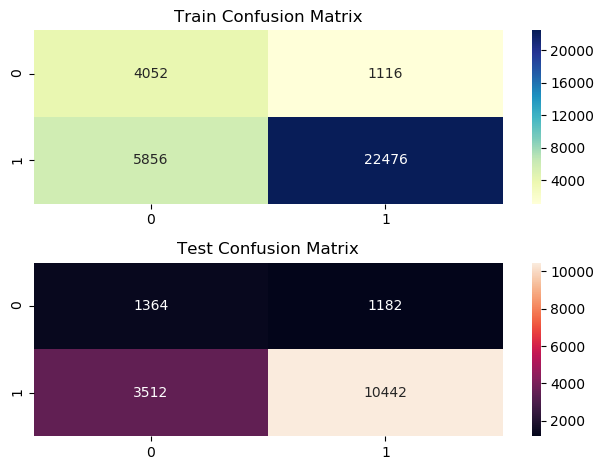

In [141]:
rf_tr_tf, rf_te_tf = predict(X_tr,X_te,y_train,y_test,RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))

In [315]:
np.array(X_train_title_avg_w2v).shape

(49039, 300)

In [313]:
type(X_train_title_cnt_std)

numpy.ndarray

In [314]:
type(X_train_essay_avg_w2v)

list

In [337]:
sparse.csr_matrix(X_train_essay_avg_w2v).shape

(49039, 300)

### 2.4.3 Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [142]:
from scipy.sparse import hstack
from scipy import sparse
X_tr = hstack((X_train_cat, X_train_subcat, sparse.csr_matrix(X_train_essay_avg_w2v), sparse.csr_matrix(X_train_title_avg_w2v), X_train_state, X_train_teacher, X_train_grade, X_train_price_std, X_train_teach_prev_std,X_train_essay_cnt_std,X_train['pos'].values.reshape(-1,1),X_train['neg'].values.reshape(-1,1),X_train['neu'].values.reshape(-1,1),X_train['compound'].values.reshape(-1,1))).tocsr()
X_te = hstack((X_test_cat, X_test_subcat, sparse.csr_matrix(X_test_essay_avg_w2v), sparse.csr_matrix(X_test_title_avg_w2v), X_test_state, X_test_teacher, X_test_grade, X_test_price_std, X_test_teach_prev_std,X_test_essay_cnt_std,X_test['pos'].values.reshape(-1,1),X_test['neg'].values.reshape(-1,1),X_test['neu'].values.reshape(-1,1),X_test['compound'].values.reshape(-1,1))).tocsr()
#X_cr = hstack((X_cv_cat, X_cv_subcat, sparse.csr_matrix(X_cv_essay_avg_w2v), sparse.csr_matrix(X_cv_title_avg_w2v), X_cv_state, X_cv_teacher, X_cv_grade, X_cv_price_std, X_cv_teach_prev_std,X_cv_essay_cnt_std,X_cv['pos'].values.reshape(-1,1),X_cv['neg'].values.reshape(-1,1),X_cv['neu'].values.reshape(-1,1),X_cv['compound'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
#print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 617) (33500,)
(16500, 617) (16500,)


#### 2.4.3.2 HyperParameter Tuning and Heat Map

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=7, n_estimators=300 ...................................
[CV]  max_depth=7, n_estimators=300, score=0.6878983373414425, total= 1.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


[CV] max_depth=7, n_estimators=300 ...................................
[CV]  max_depth=7, n_estimators=300, score=0.6853879532537219, total= 1.9min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.0min remaining:    0.0s


[CV] max_depth=7, n_estimators=300 ...................................
[CV]  max_depth=7, n_estimators=300, score=0.6856020525171671, total= 1.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.9min remaining:    0.0s


[CV] max_depth=7, n_estimators=500 ...................................
[CV]  max_depth=7, n_estimators=500, score=0.6878440723863773, total= 3.1min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.2min remaining:    0.0s


[CV] max_depth=7, n_estimators=500 ...................................
[CV]  max_depth=7, n_estimators=500, score=0.6899305998545232, total= 3.1min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.4min remaining:    0.0s


[CV] max_depth=7, n_estimators=500 ...................................
[CV]  max_depth=7, n_estimators=500, score=0.68419803071692, total= 3.1min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 15.7min remaining:    0.0s


[CV] max_depth=7, n_estimators=700 ...................................
[CV]  max_depth=7, n_estimators=700, score=0.6871397956196197, total= 4.3min


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 20.2min remaining:    0.0s


[CV] max_depth=7, n_estimators=700 ...................................
[CV]  max_depth=7, n_estimators=700, score=0.6890468124040223, total= 4.4min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 24.8min remaining:    0.0s


[CV] max_depth=7, n_estimators=700 ...................................
[CV]  max_depth=7, n_estimators=700, score=0.6864725177475046, total= 4.4min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 29.4min remaining:    0.0s


[CV] max_depth=7, n_estimators=1000 ..................................
[CV]  max_depth=7, n_estimators=1000, score=0.6891402243312013, total= 6.2min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 35.9min remaining:    0.0s


[CV] max_depth=7, n_estimators=1000 ..................................
[CV]  max_depth=7, n_estimators=1000, score=0.6884972184140474, total= 6.3min


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 42.5min remaining:    0.0s


[CV] max_depth=7, n_estimators=1000 ..................................
[CV]  max_depth=7, n_estimators=1000, score=0.6865677056661654, total= 6.3min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 49.0min remaining:    0.0s


[CV] max_depth=8, n_estimators=300 ...................................
[CV]  max_depth=8, n_estimators=300, score=0.6878014224669943, total= 2.3min


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed: 51.4min remaining:    0.0s


[CV] max_depth=8, n_estimators=300 ...................................
[CV]  max_depth=8, n_estimators=300, score=0.6873671799160423, total= 2.3min


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed: 53.8min remaining:    0.0s


[CV] max_depth=8, n_estimators=300 ...................................
[CV]  max_depth=8, n_estimators=300, score=0.685637348295792, total= 2.4min


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 56.3min remaining:    0.0s


[CV] max_depth=8, n_estimators=500 ...................................
[CV]  max_depth=8, n_estimators=500, score=0.6895279452842095, total= 4.1min


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 60.5min remaining:    0.0s


[CV] max_depth=8, n_estimators=500 ...................................
[CV]  max_depth=8, n_estimators=500, score=0.6871365999484267, total= 4.2min


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed: 64.9min remaining:    0.0s


[CV] max_depth=8, n_estimators=500 ...................................
[CV]  max_depth=8, n_estimators=500, score=0.6846335092957029, total= 3.8min


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 68.9min remaining:    0.0s


[CV] max_depth=8, n_estimators=700 ...................................
[CV]  max_depth=8, n_estimators=700, score=0.6887725992335797, total= 5.3min


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed: 74.4min remaining:    0.0s


[CV] max_depth=8, n_estimators=700 ...................................
[CV]  max_depth=8, n_estimators=700, score=0.6867751818275454, total= 5.8min


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 80.4min remaining:    0.0s


[CV] max_depth=8, n_estimators=700 ...................................
[CV]  max_depth=8, n_estimators=700, score=0.6872345745149229, total= 5.6min


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 86.2min remaining:    0.0s


[CV] max_depth=8, n_estimators=1000 ..................................
[CV]  max_depth=8, n_estimators=1000, score=0.6887388603204078, total= 8.2min


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed: 94.7min remaining:    0.0s


[CV] max_depth=8, n_estimators=1000 ..................................
[CV]  max_depth=8, n_estimators=1000, score=0.6872778240330699, total= 7.7min


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed: 102.7min remaining:    0.0s


[CV] max_depth=8, n_estimators=1000 ..................................
[CV]  max_depth=8, n_estimators=1000, score=0.6858604987846937, total= 7.6min


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 110.6min remaining:    0.0s


[CV] max_depth=9, n_estimators=300 ...................................
[CV]  max_depth=9, n_estimators=300, score=0.6848641089989363, total= 2.7min


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 113.4min remaining:    0.0s


[CV] max_depth=9, n_estimators=300 ...................................
[CV]  max_depth=9, n_estimators=300, score=0.6802204300242649, total= 2.7min


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed: 116.2min remaining:    0.0s


[CV] max_depth=9, n_estimators=300 ...................................
[CV]  max_depth=9, n_estimators=300, score=0.6836348355315102, total= 2.8min


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 119.1min remaining:    0.0s


[CV] max_depth=9, n_estimators=500 ...................................
[CV]  max_depth=9, n_estimators=500, score=0.6901265805359534, total= 4.6min


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed: 123.8min remaining:    0.0s


[CV] max_depth=9, n_estimators=500 ...................................
[CV]  max_depth=9, n_estimators=500, score=0.6853145142714988, total= 4.6min


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed: 128.5min remaining:    0.0s


[CV] max_depth=9, n_estimators=500 ...................................
[CV]  max_depth=9, n_estimators=500, score=0.6859270319423106, total= 4.6min


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 133.3min remaining:    0.0s


[CV] max_depth=9, n_estimators=700 ...................................
[CV]  max_depth=9, n_estimators=700, score=0.6892953987497059, total= 6.4min


[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed: 139.8min remaining:    0.0s


[CV] max_depth=9, n_estimators=700 ...................................
[CV]  max_depth=9, n_estimators=700, score=0.6862716177937922, total= 6.4min


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 146.5min remaining:    0.0s


[CV] max_depth=9, n_estimators=700 ...................................
[CV]  max_depth=9, n_estimators=700, score=0.6867989729543329, total= 6.4min


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 153.1min remaining:    0.0s


[CV] max_depth=9, n_estimators=1000 ..................................
[CV]  max_depth=9, n_estimators=1000, score=0.6892952758392754, total= 9.2min


[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed: 162.6min remaining:    0.0s


[CV] max_depth=9, n_estimators=1000 ..................................
[CV]  max_depth=9, n_estimators=1000, score=0.6874692570285715, total= 9.1min


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 172.0min remaining:    0.0s


[CV] max_depth=9, n_estimators=1000 ..................................
[CV]  max_depth=9, n_estimators=1000, score=0.6848666828018799, total= 9.2min


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 181.5min remaining:    0.0s


[CV] max_depth=10, n_estimators=300 ..................................
[CV]  max_depth=10, n_estimators=300, score=0.6818074187752565, total= 3.2min


[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed: 184.8min remaining:    0.0s


[CV] max_depth=10, n_estimators=300 ..................................
[CV]  max_depth=10, n_estimators=300, score=0.680392688992609, total= 3.2min


[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed: 188.1min remaining:    0.0s


[CV] max_depth=10, n_estimators=300 ..................................
[CV]  max_depth=10, n_estimators=300, score=0.6857484623584664, total= 3.2min


[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed: 191.5min remaining:    0.0s


[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=10, n_estimators=500, score=0.6871300242403952, total= 5.3min


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 197.0min remaining:    0.0s


[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=10, n_estimators=500, score=0.6835769909707539, total= 5.3min


[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed: 202.4min remaining:    0.0s


[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=10, n_estimators=500, score=0.6848894344361849, total= 5.4min


[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed: 208.0min remaining:    0.0s


[CV] max_depth=10, n_estimators=700 ..................................
[CV]  max_depth=10, n_estimators=700, score=0.6860849168498646, total= 7.5min


[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed: 215.7min remaining:    0.0s


[CV] max_depth=10, n_estimators=700 ..................................
[CV]  max_depth=10, n_estimators=700, score=0.6834471975561474, total= 7.5min


[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed: 223.4min remaining:    0.0s


[CV] max_depth=10, n_estimators=700 ..................................
[CV]  max_depth=10, n_estimators=700, score=0.6836995239620213, total= 7.5min


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 231.1min remaining:    0.0s


[CV] max_depth=10, n_estimators=1000 .................................
[CV]  max_depth=10, n_estimators=1000, score=0.6865113545884799, total=10.7min


[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed: 242.1min remaining:    0.0s


[CV] max_depth=10, n_estimators=1000 .................................
[CV]  max_depth=10, n_estimators=1000, score=0.6838632493633854, total=10.8min


[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed: 253.2min remaining:    0.0s


[CV] max_depth=10, n_estimators=1000 .................................
[CV]  max_depth=10, n_estimators=1000, score=0.6864130560437933, total=10.7min


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 264.2min finished


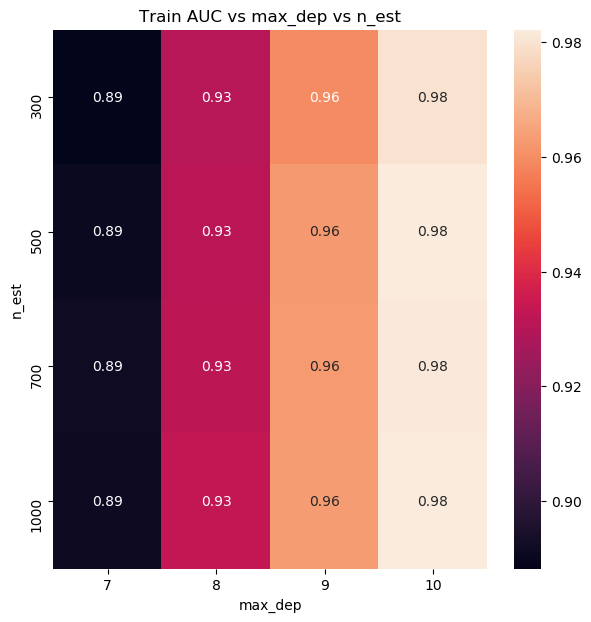

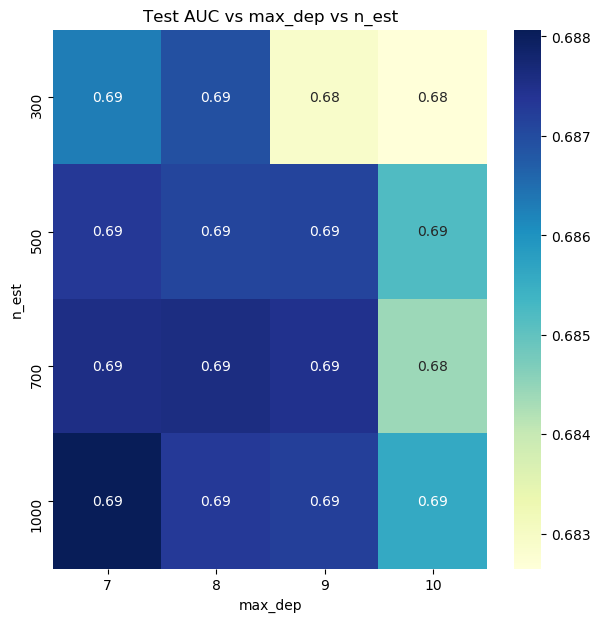

0.6880684276001372
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'max_depth': 7, 'n_estimators': 1000}


In [133]:
result = rf_tune(X_tr,y_train)

In [ ]:
print(time()-t1)

#### 2.4.3.3 Predicting with best threshold

(16500,)
(16500,)


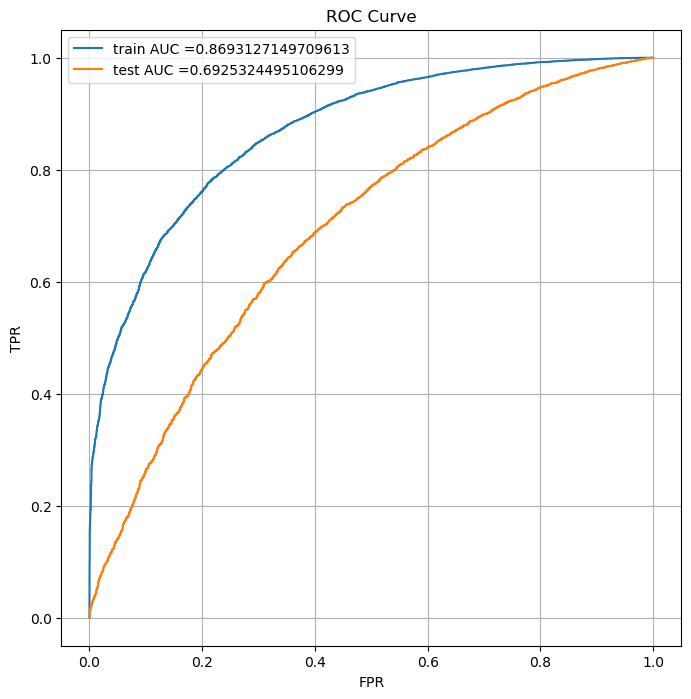

the maximum value of tpr*(1-fpr) 0.6127760979500475 for threshold 0.516


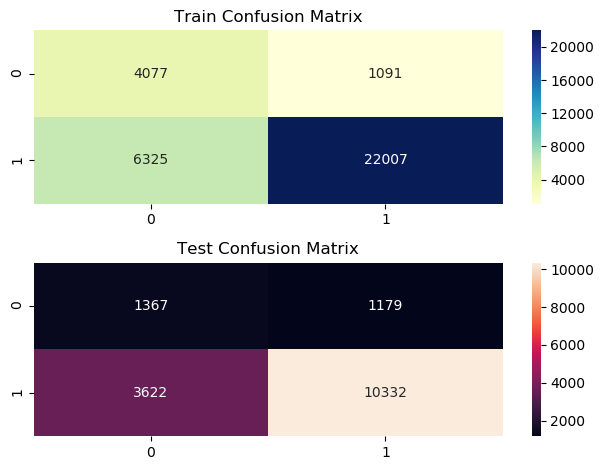

In [143]:
rf_tr_awv, rf_te_awv = predict(X_tr,X_te,y_train,y_test,RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))

### 2.4.4 Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [144]:
from scipy.sparse import hstack
X_tr = hstack((X_train_cat, X_train_subcat, sparse.csr_matrix(X_train_essay_tfidf_w2v), sparse.csr_matrix(X_train_title_tfidf_w2v), X_train_state, X_train_teacher, X_train_grade, X_train_price_std, X_train_teach_prev_std,X_train_essay_cnt_std,X_train['pos'].values.reshape(-1,1),X_train['neg'].values.reshape(-1,1),X_train['neu'].values.reshape(-1,1),X_train['compound'].values.reshape(-1,1))).tocsr()
X_te = hstack((X_test_cat, X_test_subcat, sparse.csr_matrix(X_test_essay_tfidf_w2v), sparse.csr_matrix(X_test_title_tfidf_w2v), X_test_state, X_test_teacher, X_test_grade, X_test_price_std, X_test_teach_prev_std,X_test_essay_cnt_std,X_test['pos'].values.reshape(-1,1),X_test['neg'].values.reshape(-1,1),X_test['neu'].values.reshape(-1,1),X_test['compound'].values.reshape(-1,1))).tocsr()
#X_cr = hstack((X_cv_cat, X_cv_subcat, sparse.csr_matrix(X_cv_essay_tfidf_w2v), sparse.csr_matrix(X_cv_title_tfidf_w2v), X_cv_state, X_cv_teacher, X_cv_grade, X_cv_price_std, X_cv_teach_prev_std,X_cv_essay_cnt_std,X_cv['pos'].values.reshape(-1,1),X_cv['neg'].values.reshape(-1,1),X_cv['neu'].values.reshape(-1,1),X_cv['compound'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
#print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 617) (33500,)
(16500, 617) (16500,)


#### 2.4.4.1 HyperParameter Tuning and Heat Map

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=7, n_estimators=300 ...................................
[CV]  max_depth=7, n_estimators=300, score=0.6954553315226168, total= 2.0min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[CV] max_depth=7, n_estimators=300 ...................................
[CV]  max_depth=7, n_estimators=300, score=0.6856288576974993, total= 2.0min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.2min remaining:    0.0s


[CV] max_depth=7, n_estimators=300 ...................................
[CV]  max_depth=7, n_estimators=300, score=0.6894401917335564, total= 2.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.3min remaining:    0.0s


[CV] max_depth=7, n_estimators=500 ...................................
[CV]  max_depth=7, n_estimators=500, score=0.6958082688237939, total= 3.4min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.9min remaining:    0.0s


[CV] max_depth=7, n_estimators=500 ...................................
[CV]  max_depth=7, n_estimators=500, score=0.6887960751258049, total= 3.6min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.6min remaining:    0.0s


[CV] max_depth=7, n_estimators=500 ...................................
[CV]  max_depth=7, n_estimators=500, score=0.6891098011089024, total= 3.3min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 17.1min remaining:    0.0s


[CV] max_depth=7, n_estimators=700 ...................................
[CV]  max_depth=7, n_estimators=700, score=0.6974066882448219, total= 4.9min


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 22.2min remaining:    0.0s


[CV] max_depth=7, n_estimators=700 ...................................
[CV]  max_depth=7, n_estimators=700, score=0.6883202273941292, total= 4.8min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 27.2min remaining:    0.0s


[CV] max_depth=7, n_estimators=700 ...................................
[CV]  max_depth=7, n_estimators=700, score=0.6914875313665099, total= 4.8min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 32.2min remaining:    0.0s


[CV] max_depth=7, n_estimators=1000 ..................................
[CV]  max_depth=7, n_estimators=1000, score=0.6966145919754729, total= 7.3min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 39.9min remaining:    0.0s


[CV] max_depth=7, n_estimators=1000 ..................................
[CV]  max_depth=7, n_estimators=1000, score=0.6887384915891164, total= 6.8min


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 46.9min remaining:    0.0s


[CV] max_depth=7, n_estimators=1000 ..................................
[CV]  max_depth=7, n_estimators=1000, score=0.6885127859265523, total= 6.6min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 53.8min remaining:    0.0s


[CV] max_depth=8, n_estimators=300 ...................................
[CV]  max_depth=8, n_estimators=300, score=0.6932146743746256, total= 2.4min


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed: 56.2min remaining:    0.0s


[CV] max_depth=8, n_estimators=300 ...................................
[CV]  max_depth=8, n_estimators=300, score=0.6870544957808538, total= 2.4min


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed: 58.8min remaining:    0.0s


[CV] max_depth=8, n_estimators=300 ...................................
[CV]  max_depth=8, n_estimators=300, score=0.6881542939589861, total= 2.4min


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 61.2min remaining:    0.0s


[CV] max_depth=8, n_estimators=500 ...................................
[CV]  max_depth=8, n_estimators=500, score=0.6949753355639118, total= 4.3min


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 65.7min remaining:    0.0s


[CV] max_depth=8, n_estimators=500 ...................................
[CV]  max_depth=8, n_estimators=500, score=0.6864155459079061, total= 4.2min


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed: 70.1min remaining:    0.0s


[CV] max_depth=8, n_estimators=500 ...................................
[CV]  max_depth=8, n_estimators=500, score=0.6897763010122386, total= 4.0min


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 74.2min remaining:    0.0s


[CV] max_depth=8, n_estimators=700 ...................................
[CV]  max_depth=8, n_estimators=700, score=0.6954787766872346, total= 5.5min


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed: 79.9min remaining:    0.0s


[CV] max_depth=8, n_estimators=700 ...................................
[CV]  max_depth=8, n_estimators=700, score=0.6877749352692217, total= 5.5min


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 85.6min remaining:    0.0s


[CV] max_depth=8, n_estimators=700 ...................................
[CV]  max_depth=8, n_estimators=700, score=0.6904102107367053, total= 5.5min


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 91.4min remaining:    0.0s


[CV] max_depth=8, n_estimators=1000 ..................................
[CV]  max_depth=8, n_estimators=1000, score=0.6957141501616395, total= 8.0min


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed: 99.6min remaining:    0.0s


[CV] max_depth=8, n_estimators=1000 ..................................
[CV]  max_depth=8, n_estimators=1000, score=0.6881478455153549, total= 7.8min


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed: 107.6min remaining:    0.0s


[CV] max_depth=8, n_estimators=1000 ..................................
[CV]  max_depth=8, n_estimators=1000, score=0.6891426372513861, total= 7.9min


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 115.8min remaining:    0.0s


[CV] max_depth=9, n_estimators=300 ...................................
[CV]  max_depth=9, n_estimators=300, score=0.693273671381265, total= 2.9min


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 118.8min remaining:    0.0s


[CV] max_depth=9, n_estimators=300 ...................................
[CV]  max_depth=9, n_estimators=300, score=0.6836205012631504, total= 2.8min


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed: 121.7min remaining:    0.0s


[CV] max_depth=9, n_estimators=300 ...................................
[CV]  max_depth=9, n_estimators=300, score=0.6870568658037279, total= 2.9min


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 124.7min remaining:    0.0s


[CV] max_depth=9, n_estimators=500 ...................................
[CV]  max_depth=9, n_estimators=500, score=0.6918378010045716, total= 4.7min


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed: 129.6min remaining:    0.0s


[CV] max_depth=9, n_estimators=500 ...................................
[CV]  max_depth=9, n_estimators=500, score=0.6835513641459949, total= 4.7min


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed: 134.5min remaining:    0.0s


[CV] max_depth=9, n_estimators=500 ...................................
[CV]  max_depth=9, n_estimators=500, score=0.6850081733708968, total= 4.8min


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 139.4min remaining:    0.0s


[CV] max_depth=9, n_estimators=700 ...................................
[CV]  max_depth=9, n_estimators=700, score=0.6968876374968259, total= 6.6min


[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed: 146.3min remaining:    0.0s


[CV] max_depth=9, n_estimators=700 ...................................
[CV]  max_depth=9, n_estimators=700, score=0.6856606914989984, total= 6.5min


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 153.0min remaining:    0.0s


[CV] max_depth=9, n_estimators=700 ...................................
[CV]  max_depth=9, n_estimators=700, score=0.688706666745375, total= 6.9min


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 160.1min remaining:    0.0s


[CV] max_depth=9, n_estimators=1000 ..................................
[CV]  max_depth=9, n_estimators=1000, score=0.6953199149558149, total=10.1min


[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed: 170.5min remaining:    0.0s


[CV] max_depth=9, n_estimators=1000 ..................................
[CV]  max_depth=9, n_estimators=1000, score=0.6859852364907302, total= 9.8min


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 180.6min remaining:    0.0s


[CV] max_depth=9, n_estimators=1000 ..................................
[CV]  max_depth=9, n_estimators=1000, score=0.6891784249572392, total= 9.5min


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 190.4min remaining:    0.0s


[CV] max_depth=10, n_estimators=300 ..................................
[CV]  max_depth=10, n_estimators=300, score=0.6871679728358115, total= 3.4min


[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed: 193.9min remaining:    0.0s


[CV] max_depth=10, n_estimators=300 ..................................
[CV]  max_depth=10, n_estimators=300, score=0.6791920999074976, total= 3.5min


[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed: 197.4min remaining:    0.0s


[CV] max_depth=10, n_estimators=300 ..................................
[CV]  max_depth=10, n_estimators=300, score=0.6848738157466889, total= 3.5min


[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed: 201.0min remaining:    0.0s


[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=10, n_estimators=500, score=0.6909473149356085, total= 5.7min


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 206.8min remaining:    0.0s


[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=10, n_estimators=500, score=0.6829061458410921, total= 5.7min


[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed: 212.6min remaining:    0.0s


[CV] max_depth=10, n_estimators=500 ..................................
[CV]  max_depth=10, n_estimators=500, score=0.6868075201899233, total= 5.9min


[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed: 218.7min remaining:    0.0s


[CV] max_depth=10, n_estimators=700 ..................................
[CV]  max_depth=10, n_estimators=700, score=0.6942578459258757, total= 8.1min


[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed: 227.0min remaining:    0.0s


[CV] max_depth=10, n_estimators=700 ..................................
[CV]  max_depth=10, n_estimators=700, score=0.6822893813008495, total= 8.2min


[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed: 235.4min remaining:    0.0s


[CV] max_depth=10, n_estimators=700 ..................................
[CV]  max_depth=10, n_estimators=700, score=0.6870429688595306, total= 8.2min


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 243.8min remaining:    0.0s


[CV] max_depth=10, n_estimators=1000 .................................
[CV]  max_depth=10, n_estimators=1000, score=0.6933840756754605, total=11.2min


[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed: 255.3min remaining:    0.0s


[CV] max_depth=10, n_estimators=1000 .................................
[CV]  max_depth=10, n_estimators=1000, score=0.6816930198920699, total=11.2min


[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed: 266.8min remaining:    0.0s


[CV] max_depth=10, n_estimators=1000 .................................
[CV]  max_depth=10, n_estimators=1000, score=0.6866260605336132, total=11.2min


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 278.3min finished


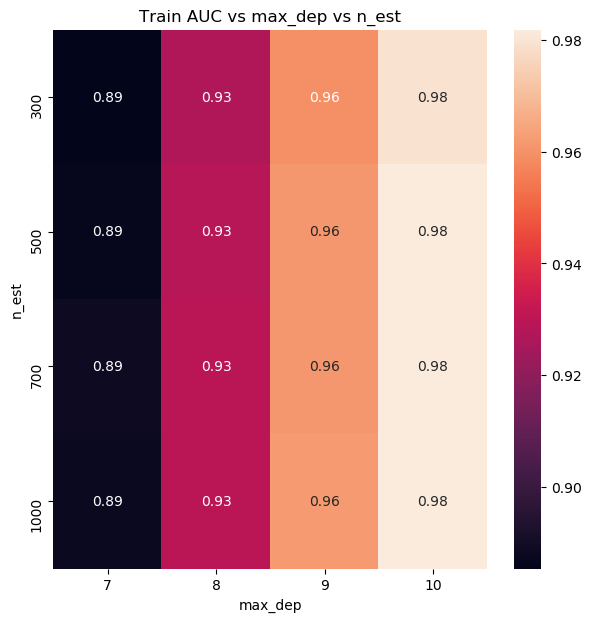

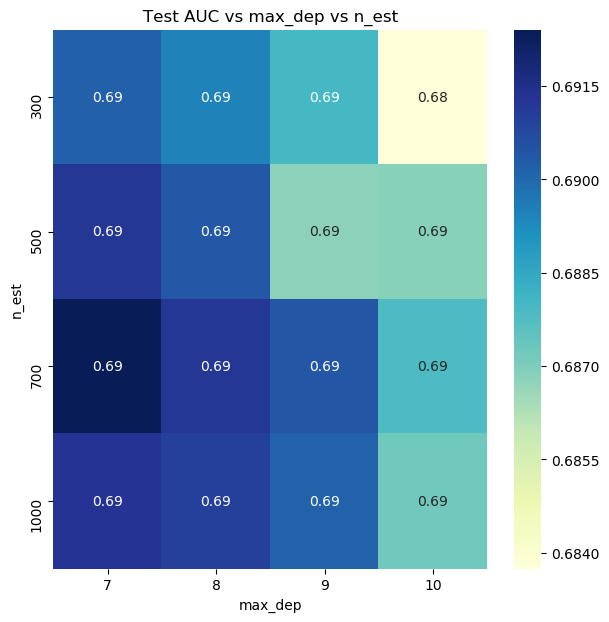

0.692404843050108
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'max_depth': 7, 'n_estimators': 700}


In [136]:
result = rf_tune(X_tr,y_train)

#### 2.4.4.2 Predicting with best threshold

(16500,)
(16500,)


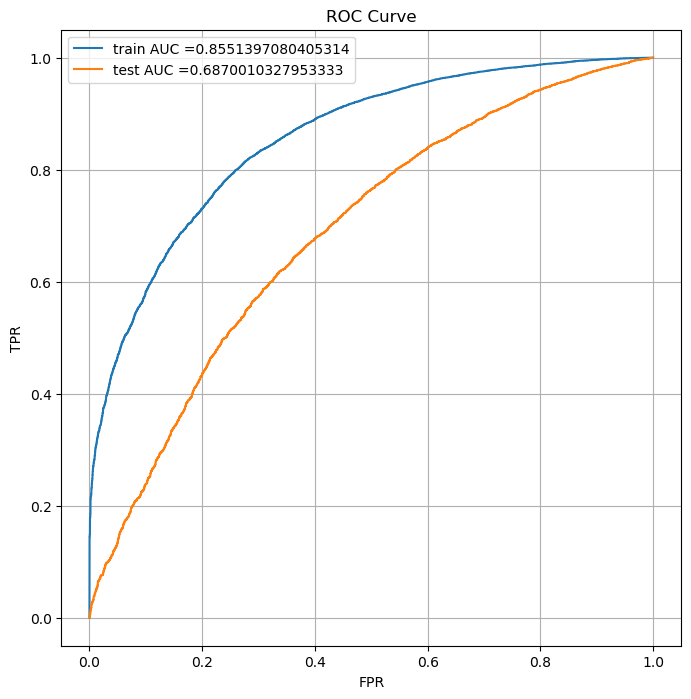

the maximum value of tpr*(1-fpr) 0.5931039807081797 for threshold 0.505


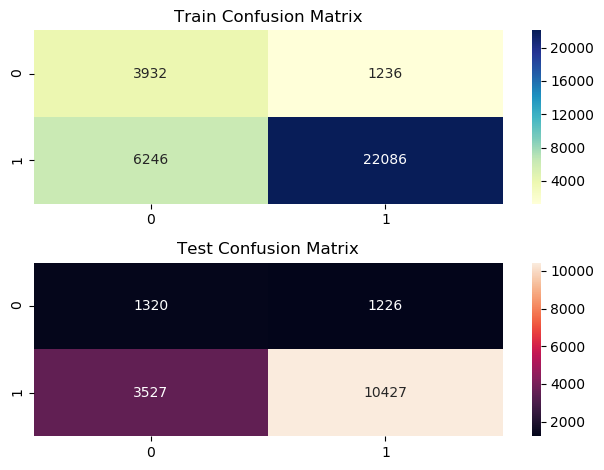

In [145]:
rf_tr_twv, rf_te_twv = predict(X_tr,X_te,y_train,y_test,RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))

<h2>2.5 Applying GBDT</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [103]:
def xg_tune(X_train,y_train):
    
    params = {'n_estimators': [300, 500, 700 ,1000] , 'max_depth':[2,3,4]}  ## Because we know gbdt needs shallow trees
    bm = XGBClassifier()
    clf = GridSearchCV(bm, param_grid=params,cv = 3,scoring='roc_auc', verbose=45)
    clf.fit(X_train,y_train)
    
    cv_res = clf.cv_results_
    
    df1 = pd.DataFrame(data=list(cv_res['param_max_depth']),columns = ['max_dep'])
    df1['n_est'] = cv_res['param_n_estimators']
    df1['Train_AUC'] = cv_res['mean_train_score']
    pivotted = df1.pivot('n_est','max_dep','Train_AUC')
    plt.figure(figsize=(7,7))
    sns.heatmap(pivotted, annot=True ,fmt = '.2f')
    plt.title("Train AUC vs max_dep vs n_est")
    plt.show()

    df2 = pd.DataFrame(data=list(cv_res['param_max_depth']),columns = ['max_dep'])
    df2['n_est'] = cv_res['param_n_estimators']
    df2['CV_AUC'] = cv_res['mean_test_score']
    pivotted = df2.pivot('n_est','max_dep','CV_AUC')
    plt.figure(figsize=(7,7))
    sns.heatmap(pivotted, annot=True ,fmt = '.2f',cmap="YlGnBu")
    plt.title("Test AUC vs max_dep vs n_est")
    plt.show()
    
    print(clf.best_score_)
    print(clf.best_estimator_)
    print(clf.best_params_)
    
    return clf

### 2.5.1 Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [146]:
# Please write all the code with proper documentation
from scipy.sparse import hstack

X_tr = hstack((X_train_cat, X_train_subcat, X_train_essay_bow, X_train_title_bow, X_train_state, X_train_teacher, X_train_grade, X_train_price_std, X_train_teach_prev_std,X_train_essay_cnt_std,X_train['pos'].values.reshape(-1,1),X_train['neg'].values.reshape(-1,1),X_train['neu'].values.reshape(-1,1),X_train['compound'].values.reshape(-1,1))).tocsr()
X_te = hstack((X_test_cat, X_test_subcat, X_test_essay_bow, X_test_title_bow, X_test_state, X_test_teacher, X_test_grade, X_test_price_std, X_test_teach_prev_std,X_test_essay_cnt_std,X_test['pos'].values.reshape(-1,1),X_test['neg'].values.reshape(-1,1),X_test['neu'].values.reshape(-1,1),X_test['compound'].values.reshape(-1,1))).tocsr()
#X_cr = hstack((X_cv_cat, X_cv_subcat, X_cv_essay_bow, X_cv_title_bow, X_cv_state, X_cv_teacher, X_cv_grade, X_cv_price_std, X_cv_teach_prev_std,X_cv_essay_cnt_std,X_cv['pos'].values.reshape(-1,1),X_cv['neg'].values.reshape(-1,1),X_cv['neu'].values.reshape(-1,1),X_cv['compound'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
#print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 12005) (33500,)
(16500, 12005) (16500,)


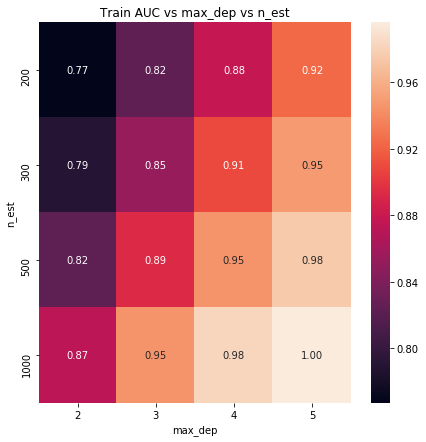

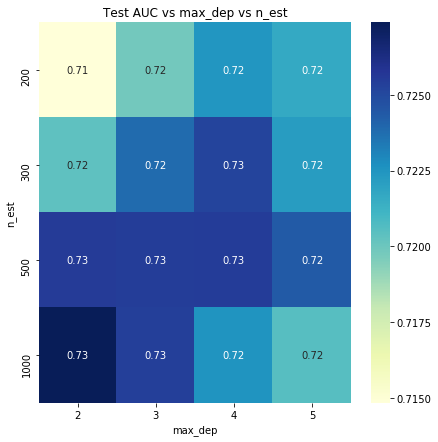

0.7273839839776833
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
{'max_depth': 2, 'n_estimators': 1000}


In [85]:
results = xg_tune(X_tr,y_train)

(16500,)
(16500,)


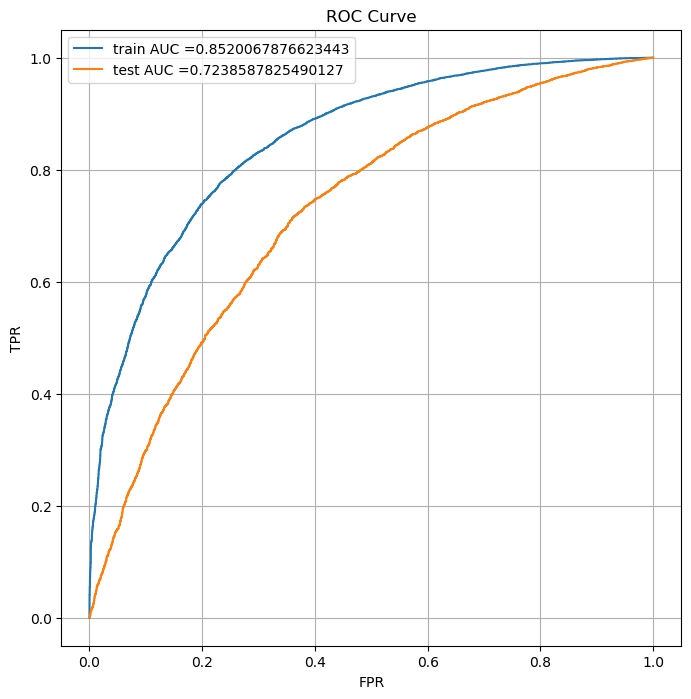

the maximum value of tpr*(1-fpr) 0.5960293232520721 for threshold 0.816


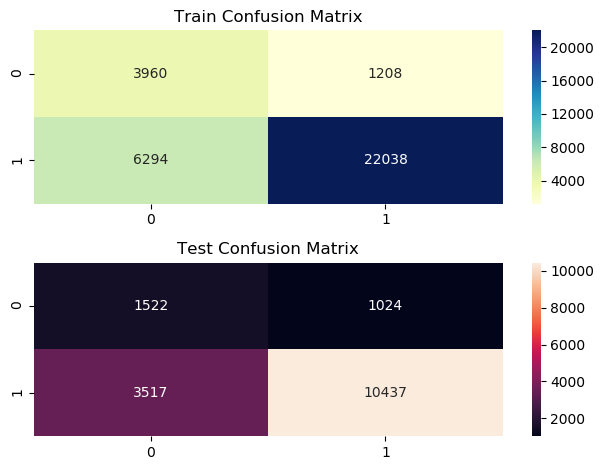

In [147]:
gb_tr_bow, gb_te_bow = predict(X_tr,X_te,y_train,y_test,XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))

### 2.5.2 Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [148]:
# Please write all the code with proper documentation
from scipy.sparse import hstack

X_tr = hstack((X_train_cat, X_train_subcat, X_train_essay_tfidf, X_train_title_tfidf, X_train_state, X_train_teacher, X_train_grade, X_train_price_std, X_train_teach_prev_std,X_train_essay_cnt_std,X_train['pos'].values.reshape(-1,1),X_train['neg'].values.reshape(-1,1),X_train['neu'].values.reshape(-1,1),X_train['compound'].values.reshape(-1,1))).tocsr()
X_te = hstack((X_test_cat, X_test_subcat, X_test_essay_tfidf, X_test_title_tfidf, X_test_state, X_test_teacher, X_test_grade, X_test_price_std, X_test_teach_prev_std,X_test_essay_cnt_std,X_test['pos'].values.reshape(-1,1),X_test['neg'].values.reshape(-1,1),X_test['neu'].values.reshape(-1,1),X_test['compound'].values.reshape(-1,1))).tocsr()
#X_cr = hstack((X_cv_cat, X_cv_subcat, X_cv_essay_tfidf, X_cv_title_tfidf, X_cv_state, X_cv_teacher, X_cv_grade, X_cv_price_std, X_cv_teach_prev_std,X_cv_essay_cnt_std,X_cv['pos'].values.reshape(-1,1),X_cv['neg'].values.reshape(-1,1),X_cv['neu'].values.reshape(-1,1),X_cv['compound'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
#print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 12005) (33500,)
(16500, 12005) (16500,)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=2, n_estimators=300 ...................................
[CV]  max_depth=2, n_estimators=300, score=0.718820819453673, total= 1.2min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] max_depth=2, n_estimators=300 ...................................
[CV]  max_depth=2, n_estimators=300, score=0.7163084687990644, total= 1.2min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


[CV] max_depth=2, n_estimators=300 ...................................
[CV]  max_depth=2, n_estimators=300, score=0.7160214795104931, total= 1.2min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.7min remaining:    0.0s


[CV] max_depth=2, n_estimators=500 ...................................
[CV]  max_depth=2, n_estimators=500, score=0.7217655075475609, total= 2.0min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.7min remaining:    0.0s


[CV] max_depth=2, n_estimators=500 ...................................
[CV]  max_depth=2, n_estimators=500, score=0.7212958667926253, total= 2.0min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.6min remaining:    0.0s


[CV] max_depth=2, n_estimators=500 ...................................
[CV]  max_depth=2, n_estimators=500, score=0.7198865209971759, total= 2.0min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  9.6min remaining:    0.0s


[CV] max_depth=2, n_estimators=700 ...................................
[CV]  max_depth=2, n_estimators=700, score=0.7217922405661943, total= 2.8min


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 12.4min remaining:    0.0s


[CV] max_depth=2, n_estimators=700 ...................................
[CV]  max_depth=2, n_estimators=700, score=0.7220117278674573, total= 2.8min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 15.2min remaining:    0.0s


[CV] max_depth=2, n_estimators=700 ...................................
[CV]  max_depth=2, n_estimators=700, score=0.7217325701574315, total= 2.7min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 18.0min remaining:    0.0s


[CV] max_depth=2, n_estimators=1000 ..................................
[CV]  max_depth=2, n_estimators=1000, score=0.7228057907036942, total= 3.9min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 21.9min remaining:    0.0s


[CV] max_depth=2, n_estimators=1000 ..................................
[CV]  max_depth=2, n_estimators=1000, score=0.7216812217198465, total= 3.9min


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 25.8min remaining:    0.0s


[CV] max_depth=2, n_estimators=1000 ..................................
[CV]  max_depth=2, n_estimators=1000, score=0.7223073256327046, total= 3.9min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 29.7min remaining:    0.0s


[CV] max_depth=2, n_estimators=1200 ..................................
[CV]  max_depth=2, n_estimators=1200, score=0.7223049921546273, total= 4.7min


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed: 34.3min remaining:    0.0s


[CV] max_depth=2, n_estimators=1200 ..................................
[CV]  max_depth=2, n_estimators=1200, score=0.7197267922368789, total= 4.7min


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed: 39.0min remaining:    0.0s


[CV] max_depth=2, n_estimators=1200 ..................................
[CV]  max_depth=2, n_estimators=1200, score=0.7212604737455979, total= 4.7min


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 43.7min remaining:    0.0s


[CV] max_depth=3, n_estimators=300 ...................................
[CV]  max_depth=3, n_estimators=300, score=0.7233623291329923, total= 1.7min


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 45.4min remaining:    0.0s


[CV] max_depth=3, n_estimators=300 ...................................
[CV]  max_depth=3, n_estimators=300, score=0.7219406549110216, total= 1.7min


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed: 47.2min remaining:    0.0s


[CV] max_depth=3, n_estimators=300 ...................................
[CV]  max_depth=3, n_estimators=300, score=0.718696764250271, total= 1.7min


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 48.9min remaining:    0.0s


[CV] max_depth=3, n_estimators=500 ...................................
[CV]  max_depth=3, n_estimators=500, score=0.72354294601061, total= 2.8min


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed: 51.7min remaining:    0.0s


[CV] max_depth=3, n_estimators=500 ...................................
[CV]  max_depth=3, n_estimators=500, score=0.7226584518251339, total= 2.8min


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 54.5min remaining:    0.0s


[CV] max_depth=3, n_estimators=500 ...................................
[CV]  max_depth=3, n_estimators=500, score=0.7224241890948588, total= 2.9min


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 57.4min remaining:    0.0s


[CV] max_depth=3, n_estimators=700 ...................................
[CV]  max_depth=3, n_estimators=700, score=0.7229617333123893, total= 4.0min


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed: 61.4min remaining:    0.0s


[CV] max_depth=3, n_estimators=700 ...................................
[CV]  max_depth=3, n_estimators=700, score=0.7196683175995692, total= 4.0min


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed: 65.4min remaining:    0.0s


[CV] max_depth=3, n_estimators=700 ...................................
[CV]  max_depth=3, n_estimators=700, score=0.7234757757815371, total= 4.0min


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 69.4min remaining:    0.0s


[CV] max_depth=3, n_estimators=1000 ..................................
[CV]  max_depth=3, n_estimators=1000, score=0.7225985022626581, total= 5.6min


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 75.0min remaining:    0.0s


[CV] max_depth=3, n_estimators=1000 ..................................
[CV]  max_depth=3, n_estimators=1000, score=0.71580336838493, total= 5.6min


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed: 80.6min remaining:    0.0s


[CV] max_depth=3, n_estimators=1000 ..................................
[CV]  max_depth=3, n_estimators=1000, score=0.7190904290146549, total= 5.6min


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 86.2min remaining:    0.0s


[CV] max_depth=3, n_estimators=1200 ..................................
[CV]  max_depth=3, n_estimators=1200, score=0.7206480980962895, total= 6.6min


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed: 92.8min remaining:    0.0s


[CV] max_depth=3, n_estimators=1200 ..................................
[CV]  max_depth=3, n_estimators=1200, score=0.7148378454981474, total= 6.6min


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed: 99.5min remaining:    0.0s


[CV] max_depth=3, n_estimators=1200 ..................................
[CV]  max_depth=3, n_estimators=1200, score=0.7190783767975637, total= 6.7min


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 106.2min remaining:    0.0s


[CV] max_depth=4, n_estimators=300 ...................................
[CV]  max_depth=4, n_estimators=300, score=0.7214488288233809, total= 2.2min


[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed: 108.4min remaining:    0.0s


[CV] max_depth=4, n_estimators=300 ...................................
[CV]  max_depth=4, n_estimators=300, score=0.7205870730675469, total=203.5min


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 311.9min remaining:    0.0s


[CV] max_depth=4, n_estimators=300 ...................................
[CV]  max_depth=4, n_estimators=300, score=0.7179913406050016, total= 2.2min


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 314.1min remaining:    0.0s


[CV] max_depth=4, n_estimators=500 ...................................
[CV]  max_depth=4, n_estimators=500, score=0.7209903729176208, total= 3.5min


[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed: 317.7min remaining:    0.0s


[CV] max_depth=4, n_estimators=500 ...................................
[CV]  max_depth=4, n_estimators=500, score=0.7180033114528186, total= 3.6min


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 321.3min remaining:    0.0s


[CV] max_depth=4, n_estimators=500 ...................................
[CV]  max_depth=4, n_estimators=500, score=0.7177779979152124, total= 3.6min


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 324.9min remaining:    0.0s


[CV] max_depth=4, n_estimators=700 ...................................
[CV]  max_depth=4, n_estimators=700, score=0.7204217892661338, total=18.8min


[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed: 343.7min remaining:    0.0s


[CV] max_depth=4, n_estimators=700 ...................................
[CV]  max_depth=4, n_estimators=700, score=0.7171130097495012, total= 5.2min


[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed: 348.9min remaining:    0.0s


[CV] max_depth=4, n_estimators=700 ...................................
[CV]  max_depth=4, n_estimators=700, score=0.71897547177051, total= 5.2min


[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed: 354.1min remaining:    0.0s


[CV] max_depth=4, n_estimators=1000 ..................................
[CV]  max_depth=4, n_estimators=1000, score=0.7185343766953957, total=11.6min


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 365.8min remaining:    0.0s


[CV] max_depth=4, n_estimators=1000 ..................................
[CV]  max_depth=4, n_estimators=1000, score=0.7130020860358264, total=12.9min


[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed: 378.8min remaining:    0.0s


[CV] max_depth=4, n_estimators=1000 ..................................
[CV]  max_depth=4, n_estimators=1000, score=0.7173131266845433, total= 7.8min


[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed: 386.6min remaining:    0.0s


[CV] max_depth=4, n_estimators=1200 ..................................
[CV]  max_depth=4, n_estimators=1200, score=0.717397025026776, total= 9.4min


[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed: 396.1min remaining:    0.0s


[CV] max_depth=4, n_estimators=1200 ..................................
[CV]  max_depth=4, n_estimators=1200, score=0.7120873558844476, total= 9.0min


[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed: 405.1min remaining:    0.0s


[CV] max_depth=4, n_estimators=1200 ..................................
[CV]  max_depth=4, n_estimators=1200, score=0.7163412014633852, total= 8.7min


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 413.8min finished


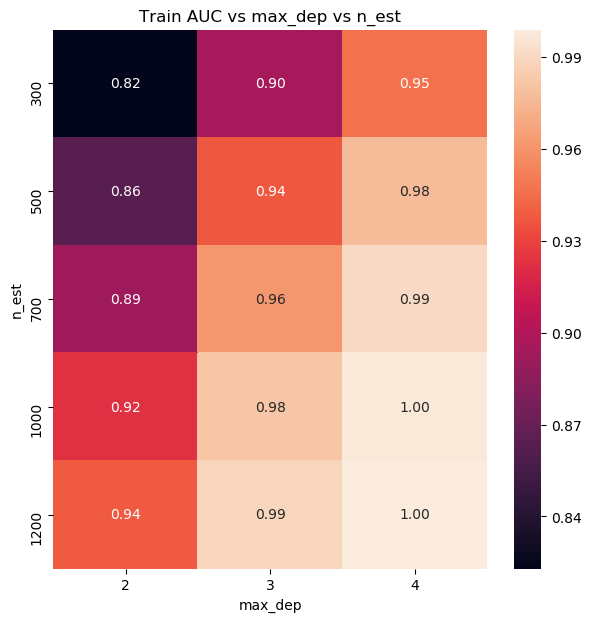

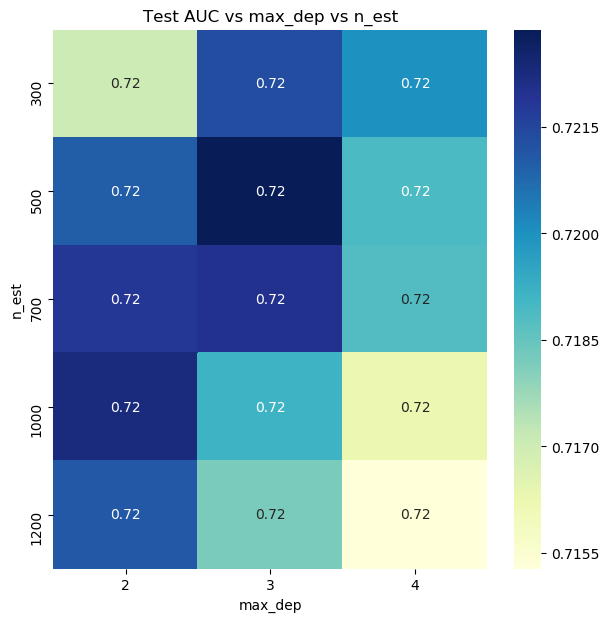

0.7228752091064162
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
{'max_depth': 3, 'n_estimators': 500}


In [99]:
results = xg_tune(X_tr,y_train)

(16500,)
(16500,)


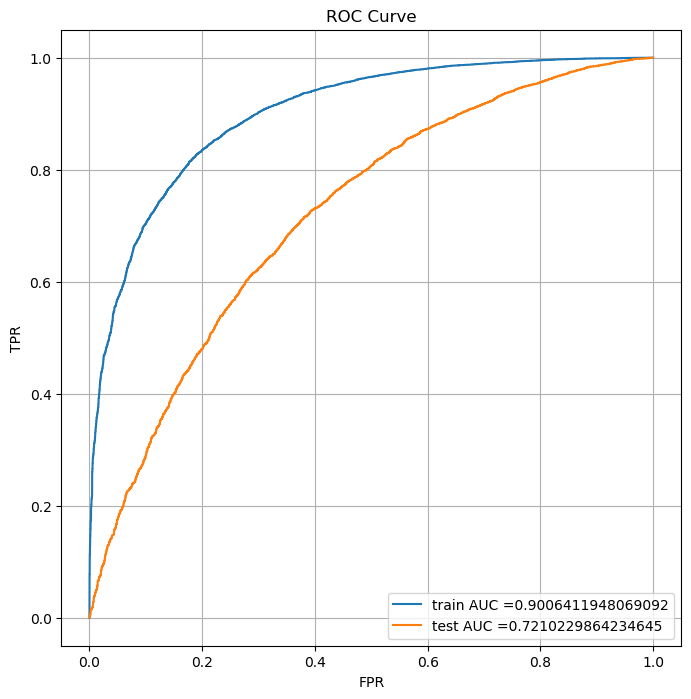

the maximum value of tpr*(1-fpr) 0.670337960358579 for threshold 0.815


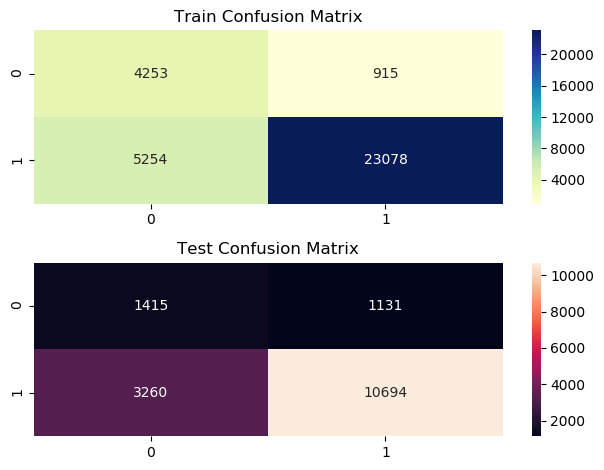

In [149]:
gb_tr_tf, gb_te_tf = predict(X_tr,X_te,y_train,y_test,XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))

### 2.5.3 Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [150]:
# Please write all the code with proper documentation
from scipy.sparse import hstack
from scipy import sparse
X_tr = hstack((X_train_cat, X_train_subcat, sparse.csr_matrix(X_train_essay_avg_w2v), sparse.csr_matrix(X_train_title_avg_w2v), X_train_state, X_train_teacher, X_train_grade, X_train_price_std, X_train_teach_prev_std,X_train_essay_cnt_std,X_train['pos'].values.reshape(-1,1),X_train['neg'].values.reshape(-1,1),X_train['neu'].values.reshape(-1,1),X_train['compound'].values.reshape(-1,1))).tocsr()
X_te = hstack((X_test_cat, X_test_subcat, sparse.csr_matrix(X_test_essay_avg_w2v), sparse.csr_matrix(X_test_title_avg_w2v), X_test_state, X_test_teacher, X_test_grade, X_test_price_std, X_test_teach_prev_std,X_test_essay_cnt_std,X_test['pos'].values.reshape(-1,1),X_test['neg'].values.reshape(-1,1),X_test['neu'].values.reshape(-1,1),X_test['compound'].values.reshape(-1,1))).tocsr()
#X_cr = hstack((X_cv_cat, X_cv_subcat, sparse.csr_matrix(X_cv_essay_avg_w2v), sparse.csr_matrix(X_cv_title_avg_w2v), X_cv_state, X_cv_teacher, X_cv_grade, X_cv_price_std, X_cv_teach_prev_std,X_cv_essay_cnt_std,X_cv['pos'].values.reshape(-1,1),X_cv['neg'].values.reshape(-1,1),X_cv['neu'].values.reshape(-1,1),X_cv['compound'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
#print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 617) (33500,)
(16500, 617) (16500,)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=2, n_estimators=300 ...................................
[CV]  max_depth=2, n_estimators=300, score=0.7167738998717553, total= 4.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min remaining:    0.0s


[CV] max_depth=2, n_estimators=300 ...................................
[CV]  max_depth=2, n_estimators=300, score=0.7108499243977942, total= 4.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.5min remaining:    0.0s


[CV] max_depth=2, n_estimators=300 ...................................
[CV]  max_depth=2, n_estimators=300, score=0.7147438522624471, total= 4.7min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.3min remaining:    0.0s


[CV] max_depth=2, n_estimators=500 ...................................
[CV]  max_depth=2, n_estimators=500, score=0.7195546869065731, total= 7.7min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 22.1min remaining:    0.0s


[CV] max_depth=2, n_estimators=500 ...................................
[CV]  max_depth=2, n_estimators=500, score=0.7118080726587468, total= 7.7min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 29.9min remaining:    0.0s


[CV] max_depth=2, n_estimators=500 ...................................
[CV]  max_depth=2, n_estimators=500, score=0.7179811638604677, total= 7.7min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 37.7min remaining:    0.0s


[CV] max_depth=2, n_estimators=700 ...................................
[CV]  max_depth=2, n_estimators=700, score=0.7200166150319949, total=10.9min


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 48.6min remaining:    0.0s


[CV] max_depth=2, n_estimators=700 ...................................
[CV]  max_depth=2, n_estimators=700, score=0.7106174700461135, total=10.9min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 59.6min remaining:    0.0s


[CV] max_depth=2, n_estimators=700 ...................................
[CV]  max_depth=2, n_estimators=700, score=0.7172977847041132, total=10.8min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 70.4min remaining:    0.0s


[CV] max_depth=2, n_estimators=1000 ..................................
[CV]  max_depth=2, n_estimators=1000, score=0.7187131806441638, total=15.3min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 85.8min remaining:    0.0s


[CV] max_depth=2, n_estimators=1000 ..................................
[CV]  max_depth=2, n_estimators=1000, score=0.7084164822395658, total=15.2min


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 101.0min remaining:    0.0s


[CV] max_depth=2, n_estimators=1000 ..................................
[CV]  max_depth=2, n_estimators=1000, score=0.7165192176290976, total=15.2min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 116.3min remaining:    0.0s


[CV] max_depth=3, n_estimators=300 ...................................
[CV]  max_depth=3, n_estimators=300, score=0.7171116884623733, total= 6.7min


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed: 123.0min remaining:    0.0s


[CV] max_depth=3, n_estimators=300 ...................................
[CV]  max_depth=3, n_estimators=300, score=0.707374601247836, total= 6.7min


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed: 129.8min remaining:    0.0s


[CV] max_depth=3, n_estimators=300 ...................................
[CV]  max_depth=3, n_estimators=300, score=0.7138813501041164, total= 6.8min


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 136.6min remaining:    0.0s


[CV] max_depth=3, n_estimators=500 ...................................
[CV]  max_depth=3, n_estimators=500, score=0.7174538096456664, total=11.0min


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 147.6min remaining:    0.0s


[CV] max_depth=3, n_estimators=500 ...................................
[CV]  max_depth=3, n_estimators=500, score=0.7032557805390016, total=11.0min


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed: 158.7min remaining:    0.0s


[CV] max_depth=3, n_estimators=500 ...................................
[CV]  max_depth=3, n_estimators=500, score=0.7139314651904913, total=11.0min


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 169.8min remaining:    0.0s


[CV] max_depth=3, n_estimators=700 ...................................
[CV]  max_depth=3, n_estimators=700, score=0.7166219825796589, total=15.6min


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed: 185.5min remaining:    0.0s


[CV] max_depth=3, n_estimators=700 ...................................
[CV]  max_depth=3, n_estimators=700, score=0.6980488337889623, total=15.4min


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 200.9min remaining:    0.0s


[CV] max_depth=3, n_estimators=700 ...................................
[CV]  max_depth=3, n_estimators=700, score=0.7131810302038399, total=15.4min


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 216.3min remaining:    0.0s


[CV] max_depth=3, n_estimators=1000 ..................................
[CV]  max_depth=3, n_estimators=1000, score=0.714458574637236, total=21.8min


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed: 238.2min remaining:    0.0s


[CV] max_depth=3, n_estimators=1000 ..................................
[CV]  max_depth=3, n_estimators=1000, score=0.6957387937029544, total=22.0min


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed: 260.2min remaining:    0.0s


[CV] max_depth=3, n_estimators=1000 ..................................
[CV]  max_depth=3, n_estimators=1000, score=0.7078486620317284, total=21.9min


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 282.1min remaining:    0.0s


[CV] max_depth=4, n_estimators=300 ...................................
[CV]  max_depth=4, n_estimators=300, score=0.7160191376456704, total= 8.7min


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 290.9min remaining:    0.0s


[CV] max_depth=4, n_estimators=300 ...................................
[CV]  max_depth=4, n_estimators=300, score=0.705395804772022, total= 8.8min


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed: 299.8min remaining:    0.0s


[CV] max_depth=4, n_estimators=300 ...................................
[CV]  max_depth=4, n_estimators=300, score=0.7111074954459837, total= 8.8min


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 308.6min remaining:    0.0s


[CV] max_depth=4, n_estimators=500 ...................................
[CV]  max_depth=4, n_estimators=500, score=0.7159085489858292, total=14.5min


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed: 323.2min remaining:    0.0s


[CV] max_depth=4, n_estimators=500 ...................................
[CV]  max_depth=4, n_estimators=500, score=0.6995868427334002, total=14.6min


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed: 337.8min remaining:    0.0s


[CV] max_depth=4, n_estimators=500 ...................................
[CV]  max_depth=4, n_estimators=500, score=0.7084957615550016, total=14.5min


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 352.3min remaining:    0.0s


[CV] max_depth=4, n_estimators=700 ...................................
[CV]  max_depth=4, n_estimators=700, score=0.7131096941177281, total=20.2min


[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed: 372.6min remaining:    0.0s


[CV] max_depth=4, n_estimators=700 ...................................
[CV]  max_depth=4, n_estimators=700, score=0.6964082868178809, total=20.2min


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 392.8min remaining:    0.0s


[CV] max_depth=4, n_estimators=700 ...................................
[CV]  max_depth=4, n_estimators=700, score=0.7071454213135342, total=20.0min


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 412.9min remaining:    0.0s


[CV] max_depth=4, n_estimators=1000 ..................................
[CV]  max_depth=4, n_estimators=1000, score=0.7116258886731401, total=28.9min


[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed: 441.8min remaining:    0.0s


[CV] max_depth=4, n_estimators=1000 ..................................
[CV]  max_depth=4, n_estimators=1000, score=0.6930074473888048, total=29.0min


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 470.9min remaining:    0.0s


[CV] max_depth=4, n_estimators=1000 ..................................
[CV]  max_depth=4, n_estimators=1000, score=0.706749173931202, total=29.1min


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 500.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 500.1min finished


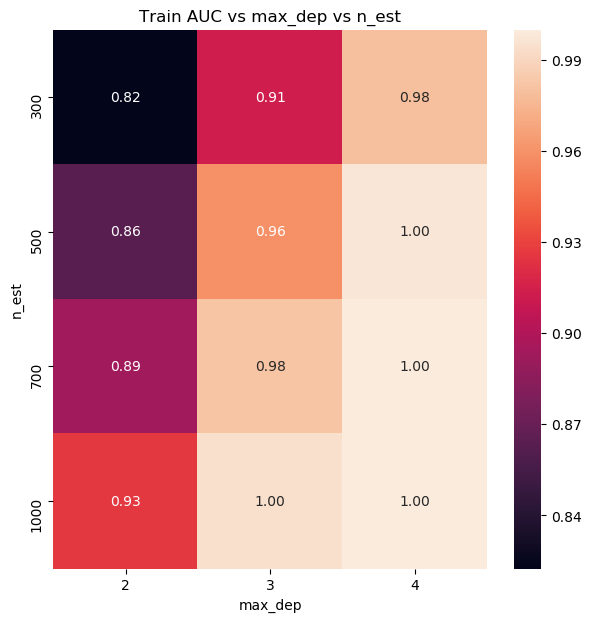

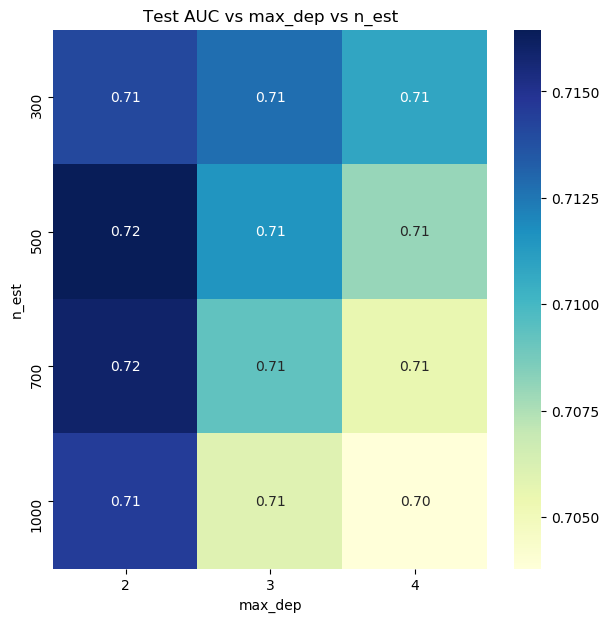

0.7164479287084152
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
{'max_depth': 2, 'n_estimators': 500}


In [104]:
results = xg_tune(X_tr,y_train)

(16500,)
(16500,)


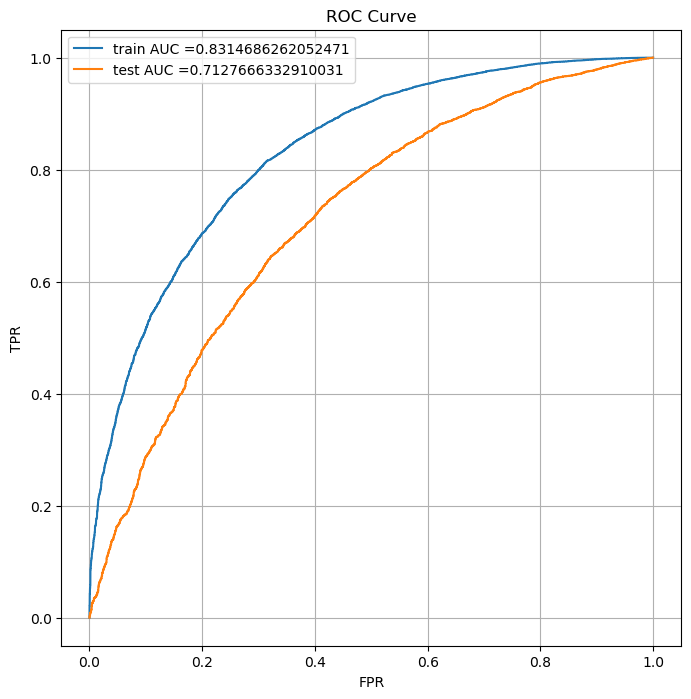

the maximum value of tpr*(1-fpr) 0.5636055064037251 for threshold 0.827


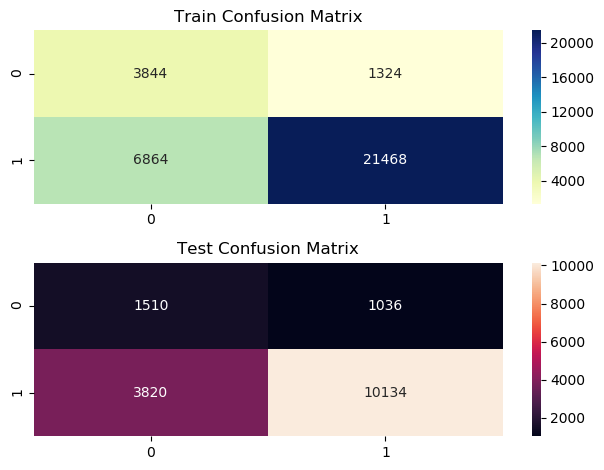

In [151]:
gb_tr_awv, gb_te_awv = predict(X_tr,X_te,y_train,y_test,XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))

### 2.5.4 Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [152]:
from scipy.sparse import hstack
X_tr = hstack((X_train_cat, X_train_subcat, sparse.csr_matrix(X_train_essay_tfidf_w2v), sparse.csr_matrix(X_train_title_tfidf_w2v), X_train_state, X_train_teacher, X_train_grade, X_train_price_std, X_train_teach_prev_std,X_train_essay_cnt_std,X_train['pos'].values.reshape(-1,1),X_train['neg'].values.reshape(-1,1),X_train['neu'].values.reshape(-1,1),X_train['compound'].values.reshape(-1,1))).tocsr()
X_te = hstack((X_test_cat, X_test_subcat, sparse.csr_matrix(X_test_essay_tfidf_w2v), sparse.csr_matrix(X_test_title_tfidf_w2v), X_test_state, X_test_teacher, X_test_grade, X_test_price_std, X_test_teach_prev_std,X_test_essay_cnt_std,X_test['pos'].values.reshape(-1,1),X_test['neg'].values.reshape(-1,1),X_test['neu'].values.reshape(-1,1),X_test['compound'].values.reshape(-1,1))).tocsr()
#X_cr = hstack((X_cv_cat, X_cv_subcat, sparse.csr_matrix(X_cv_essay_tfidf_w2v), sparse.csr_matrix(X_cv_title_tfidf_w2v), X_cv_state, X_cv_teacher, X_cv_grade, X_cv_price_std, X_cv_teach_prev_std,X_cv_essay_cnt_std,X_cv['pos'].values.reshape(-1,1),X_cv['neg'].values.reshape(-1,1),X_cv['neu'].values.reshape(-1,1),X_cv['compound'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
#print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 617) (33500,)
(16500, 617) (16500,)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=2, n_estimators=300 ...................................
[CV]  max_depth=2, n_estimators=300, score=0.7275903557593246, total= 4.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.6min remaining:    0.0s


[CV] max_depth=2, n_estimators=300 ...................................
[CV]  max_depth=2, n_estimators=300, score=0.7061515810091586, total= 4.6min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.3min remaining:    0.0s


[CV] max_depth=2, n_estimators=300 ...................................
[CV]  max_depth=2, n_estimators=300, score=0.7153242341553929, total= 4.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.0min remaining:    0.0s


[CV] max_depth=2, n_estimators=500 ...................................
[CV]  max_depth=2, n_estimators=500, score=0.7290102477800533, total= 7.6min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 21.7min remaining:    0.0s


[CV] max_depth=2, n_estimators=500 ...................................
[CV]  max_depth=2, n_estimators=500, score=0.7056348962869498, total= 7.5min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 29.3min remaining:    0.0s


[CV] max_depth=2, n_estimators=500 ...................................
[CV]  max_depth=2, n_estimators=500, score=0.7159124561385385, total= 7.6min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 36.9min remaining:    0.0s


[CV] max_depth=2, n_estimators=700 ...................................
[CV]  max_depth=2, n_estimators=700, score=0.7266654854974296, total=10.6min


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 47.6min remaining:    0.0s


[CV] max_depth=2, n_estimators=700 ...................................
[CV]  max_depth=2, n_estimators=700, score=0.7042107024011536, total=10.7min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 58.3min remaining:    0.0s


[CV] max_depth=2, n_estimators=700 ...................................
[CV]  max_depth=2, n_estimators=700, score=0.7156263697098761, total=11.2min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 69.6min remaining:    0.0s


[CV] max_depth=2, n_estimators=1000 ..................................
[CV]  max_depth=2, n_estimators=1000, score=0.7244913843475532, total=15.2min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 84.9min remaining:    0.0s


[CV] max_depth=2, n_estimators=1000 ..................................
[CV]  max_depth=2, n_estimators=1000, score=0.701242661325471, total=15.2min


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 100.2min remaining:    0.0s


[CV] max_depth=2, n_estimators=1000 ..................................
[CV]  max_depth=2, n_estimators=1000, score=0.7141964294937921, total=15.2min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 115.5min remaining:    0.0s


[CV] max_depth=3, n_estimators=300 ...................................
[CV]  max_depth=3, n_estimators=300, score=0.7219486440890039, total= 6.6min


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed: 122.2min remaining:    0.0s


[CV] max_depth=3, n_estimators=300 ...................................
[CV]  max_depth=3, n_estimators=300, score=0.7087545781062601, total= 6.6min


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed: 128.9min remaining:    0.0s


[CV] max_depth=3, n_estimators=300 ...................................
[CV]  max_depth=3, n_estimators=300, score=0.7128290870174994, total= 6.6min


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 135.6min remaining:    0.0s


[CV] max_depth=3, n_estimators=500 ...................................
[CV]  max_depth=3, n_estimators=500, score=0.7196348245072582, total=10.9min


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 146.6min remaining:    0.0s


[CV] max_depth=3, n_estimators=500 ...................................
[CV]  max_depth=3, n_estimators=500, score=0.7032069850980935, total=11.0min


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed: 157.7min remaining:    0.0s


[CV] max_depth=3, n_estimators=500 ...................................
[CV]  max_depth=3, n_estimators=500, score=0.7105337545706188, total=11.0min


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 168.7min remaining:    0.0s


[CV] max_depth=3, n_estimators=700 ...................................
[CV]  max_depth=3, n_estimators=700, score=0.7146144865183237, total=15.6min


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed: 184.3min remaining:    0.0s


[CV] max_depth=3, n_estimators=700 ...................................
[CV]  max_depth=3, n_estimators=700, score=0.697815949250775, total=15.7min


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 200.1min remaining:    0.0s


[CV] max_depth=3, n_estimators=700 ...................................
[CV]  max_depth=3, n_estimators=700, score=0.7064291137783405, total=15.7min


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 215.9min remaining:    0.0s


[CV] max_depth=3, n_estimators=1000 ..................................
[CV]  max_depth=3, n_estimators=1000, score=0.7093471907469093, total=22.2min


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed: 238.2min remaining:    0.0s


[CV] max_depth=3, n_estimators=1000 ..................................
[CV]  max_depth=3, n_estimators=1000, score=0.6948464947051416, total=21.9min


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed: 260.1min remaining:    0.0s


[CV] max_depth=3, n_estimators=1000 ..................................
[CV]  max_depth=3, n_estimators=1000, score=0.7024059176877846, total=22.1min


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 282.3min remaining:    0.0s


[CV] max_depth=4, n_estimators=300 ...................................
[CV]  max_depth=4, n_estimators=300, score=0.7215561603568139, total= 9.1min


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 291.5min remaining:    0.0s


[CV] max_depth=4, n_estimators=300 ...................................
[CV]  max_depth=4, n_estimators=300, score=0.7033046067075173, total= 9.4min


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed: 300.9min remaining:    0.0s


[CV] max_depth=4, n_estimators=300 ...................................
[CV]  max_depth=4, n_estimators=300, score=0.7105121405180289, total= 9.3min


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 310.3min remaining:    0.0s


[CV] max_depth=4, n_estimators=500 ...................................
[CV]  max_depth=4, n_estimators=500, score=0.7154966146780128, total=15.3min


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed: 325.7min remaining:    0.0s


[CV] max_depth=4, n_estimators=500 ...................................
[CV]  max_depth=4, n_estimators=500, score=0.7001470992032208, total=14.9min


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed: 340.7min remaining:    0.0s


[CV] max_depth=4, n_estimators=500 ...................................
[CV]  max_depth=4, n_estimators=500, score=0.7042667861557903, total=15.5min


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 356.3min remaining:    0.0s


[CV] max_depth=4, n_estimators=700 ...................................
[CV]  max_depth=4, n_estimators=700, score=0.7107899133801032, total=21.3min


[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed: 377.7min remaining:    0.0s


[CV] max_depth=4, n_estimators=700 ...................................
[CV]  max_depth=4, n_estimators=700, score=0.6958151825355094, total=20.5min


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 398.3min remaining:    0.0s


[CV] max_depth=4, n_estimators=700 ...................................
[CV]  max_depth=4, n_estimators=700, score=0.7007452636016649, total=20.4min


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 418.7min remaining:    0.0s


[CV] max_depth=4, n_estimators=1000 ..................................
[CV]  max_depth=4, n_estimators=1000, score=0.707775504344515, total=29.1min


[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed: 447.8min remaining:    0.0s


[CV] max_depth=4, n_estimators=1000 ..................................
[CV]  max_depth=4, n_estimators=1000, score=0.6941264239480649, total=29.6min


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 477.5min remaining:    0.0s


[CV] max_depth=4, n_estimators=1000 ..................................
[CV]  max_depth=4, n_estimators=1000, score=0.6989380766924387, total=30.5min


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 508.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 508.1min finished


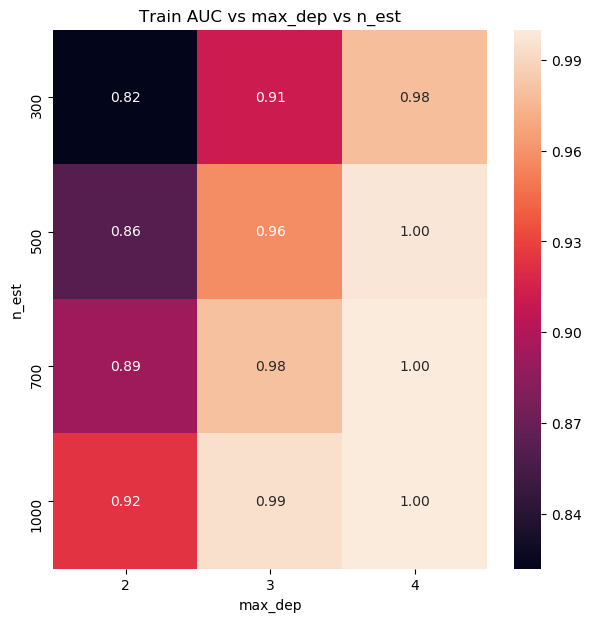

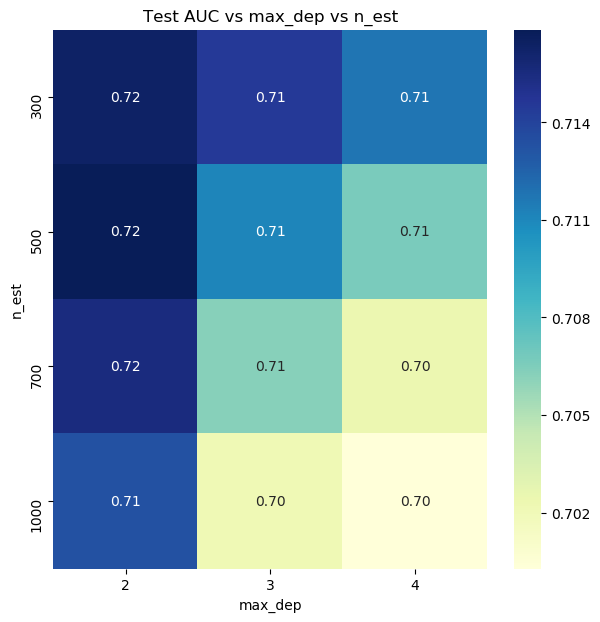

0.716852561463855
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
{'max_depth': 2, 'n_estimators': 500}


In [107]:
# Please write all the code with proper documentation
results = xg_tune(X_tr,y_train)

(16500,)
(16500,)


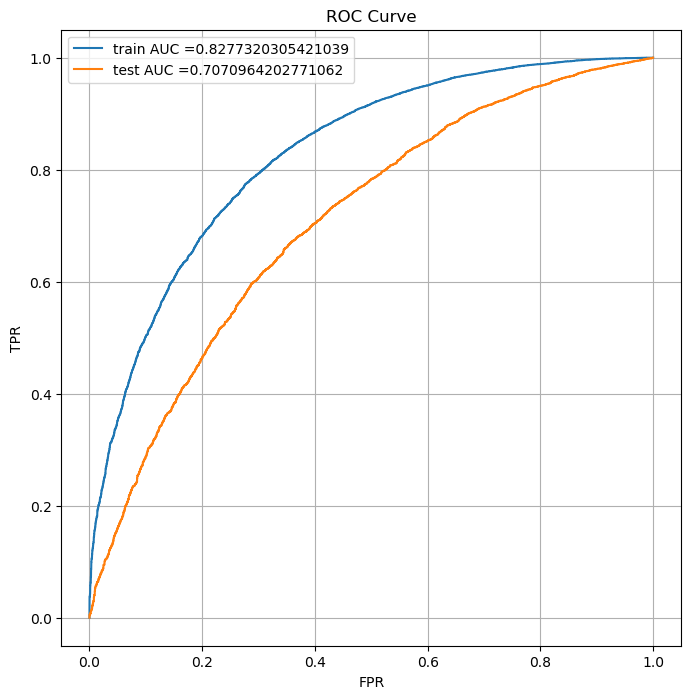

the maximum value of tpr*(1-fpr) 0.5602749385438208 for threshold 0.819


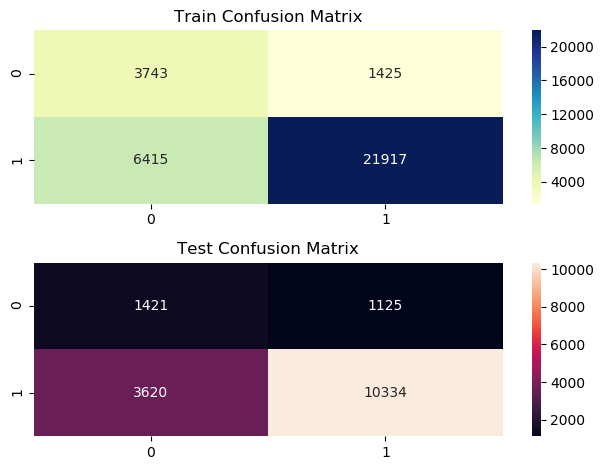

In [153]:
gb_tr_twv, gb_te_twv = predict(X_tr,X_te,y_train,y_test,XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))

<h1>3. Conclusion</h1>

In [154]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
pt = PrettyTable(["Model","Vectorization Type", "Train AUC", "Test AUC","max_depth","n_estimators"])
pt.add_row(["RF","BOW", rf_tr_auc, rf_te_auc, 10,700])
pt.add_row(["RF","Tf-Idf", rf_tr_tf, rf_te_tf, 10,1000])
pt.add_row(["RF","AVG W2V", rf_tr_awv, rf_te_awv, 7,1000])
pt.add_row(["RF","TfIdf W2V", rf_tr_twv, rf_te_twv, 7,700])
pt.add_row(["GBDT","BOW", gb_tr_bow, gb_te_bow,2,1000])
pt.add_row(["GBDT","Tf-Idf", gb_tr_tf, gb_te_tf, 3,500])
pt.add_row(["GBDT","AVG W2V", gb_tr_awv, gb_te_awv, 2,500])
pt.add_row(["GBDT","TfIdf W2V", gb_tr_twv, gb_te_twv, 2,500])


print(pt)

+-------+--------------------+--------------------+--------------------+-----------+--------------+
| Model | Vectorization Type |     Train AUC      |      Test AUC      | max_depth | n_estimators |
+-------+--------------------+--------------------+--------------------+-----------+--------------+
|   RF  |        BOW         | 0.8704793401678199 | 0.7063246244731174 |     10    |     700      |
|   RF  |       Tf-Idf       | 0.8761834603544265 | 0.7050402168678797 |     10    |     1000     |
|   RF  |      AVG W2V       | 0.8693127149709613 | 0.6925324495106299 |     7     |     1000     |
|   RF  |     TfIdf W2V      | 0.8551397080405314 | 0.6870010327953333 |     7     |     700      |
|  GBDT |        BOW         | 0.8520067876623443 | 0.7238587825490127 |     2     |     1000     |
|  GBDT |       Tf-Idf       | 0.9006411948069092 | 0.7210229864234645 |     3     |     500      |
|  GBDT |      AVG W2V       | 0.8314686262052471 | 0.7127666332910031 |     2     |     500      |


Conclusion : 

1. The highest train AUC is achieved by Tf-Idf GBDT which is 90% but the test AUC is about 72% which hints that our model might be overfitting.
2. AVG W2v and Tfidf W2V GBDT models looks decent as Train AUC and Test AUC are reasonably close to each other
3. RF models are overfitting especially Tf-Idf w2v and AVG W2v